# 데이터 작업 환경 조성

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import collections
import datetime

from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
# os.getcwd() # 현재 작업환경 반환
# os.chdir('C:/Users/82103/Desktop') # change directory
# os.chdir('../KMH') # . 하나는 현재, 2개는 이전
# os.listdir()

## 변수 설명

### 함수
* function event_plot(종목번호,보고 싶은 컬럼,data_stocks)
* function train_plot(종목번호,그룹명,보고 싶은 컬럼,data_train)

### 기본 데이터
* data_stocks - 2019년 7월 1일부터 2020년 7월 28일까지 주식거래 데이터
* data_train - 2019년 7월부터 2020년 6월까지 그룹별 거래 데이터
* data_answer 2020년 7월 그룹별 가장 많이 매수한 주식

### 설정 변수
* new_data_train - 누락데이터 제거-> data_train으로 쓰기로 결정
* m1 - MAD01그룹 거래 데이터
* m1_num -MAD01그룹이 산 주식 종목번호
* gp1 - m1_num의 표준산업구분코드_대분류 
    * gp1.append(data_stocks[data_stocks['종목번호']==m1_num[j]]['표준산업구분코드_대분류'].unique()[0]) 으로 수정가능
* counter1 - gp1을 그룹별로 묶은 것
    * counter1=collections.Counter(gp1)
    * counter1=[(l,k) for k,l in sorted([(j,i) for i,j in counter1.items()], reverse=True)] 으로 수정가능
* data_answer_1 : MAD01 그룹의 answer데이터 종목코드
* data_make_1 : data_answer_1의 표준산업구분코드_대분류
    * data_make_1.append(data_stocks[data_stocks['종목번호']==data_answer_1[j]]['표준산업구분코드_대분류'].unique()[0])으로 수정가능

* df1 - counter1과 data_make_1 데이터프레임
* ans - Answer_sheet를 데이터프레임화

### 상장폐지된 회사들
* ['흥아해운','메디앙스','디에스티','럭슬','에이프런티어', '솔브레인홀딩스', '팍스넷', '에이아이비트', '셀루메드',
 '이에스에이', '현진소재', '제낙스', '이노와이즈', '에스모머티리얼즈', '포티스', '이큐셀', '내츄럴엔도텍',
 '퓨전', '신라젠', '경남제약헬스케어', '샘코', '블러썸엠앤씨']

## Stocks Data 불러오기

In [3]:
os.getcwd()

'C:\\Users\\82103\\KMH'

In [4]:
data_stocks=pd.read_csv('./data/stocks.csv',index_col=['index'])
data_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286061 entries, 0 to 286060
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   기준일자           286061 non-null  int64 
 1   종목번호           286061 non-null  object
 2   종목명            286061 non-null  object
 3   20년7월TOP3대상여부  286061 non-null  object
 4   시장구분           286061 non-null  object
 5   표준산업구분코드_대분류   286061 non-null  object
 6   표준산업구분코드_중분류   286061 non-null  object
 7   표준산업구분코드_소분류   286061 non-null  object
 8   종목시가           286061 non-null  int64 
 9   종목고가           286061 non-null  int64 
 10  종목저가           286061 non-null  int64 
 11  종목종가           286061 non-null  int64 
 12  거래량            286061 non-null  int64 
 13  거래금액_만원단위      286061 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 32.7+ MB


<!-- ## 상장폐지된 회사들 제거 -->

In [5]:
# # 상장페지된 회사 제거 코드
# remove_temp = pd.read_csv("remove.txt")
# remove_list = []
# for i in range(4):
#     remove_list += remove_temp.iloc[i].tolist()[0].split(" ")

# for i in range(len(remove_list)):
#     ind = data_stocks[data_stocks['종목명']==remove_list[i]].index.tolist()
#     data_stocks = data_stocks.drop(index=ind).copy()
    
# remove_list

### 기준일자 데이터 시계열로 변환 / 시각화
* 종목번호를 넣으면 그래프 그려줌

In [6]:
def event_plot(e,want,ds):
    date = ds[ds['종목번호']==e]['기준일자']
    start_money = ds[ds['종목번호']==e][want]
    plot_df = pd.DataFrame(start_money)
    plot_df.index = date.apply(lambda x: datetime.datetime(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:])))
    
    plt.figure(figsize=(20,10))
    plot_df[want].plot()
    plt.show()

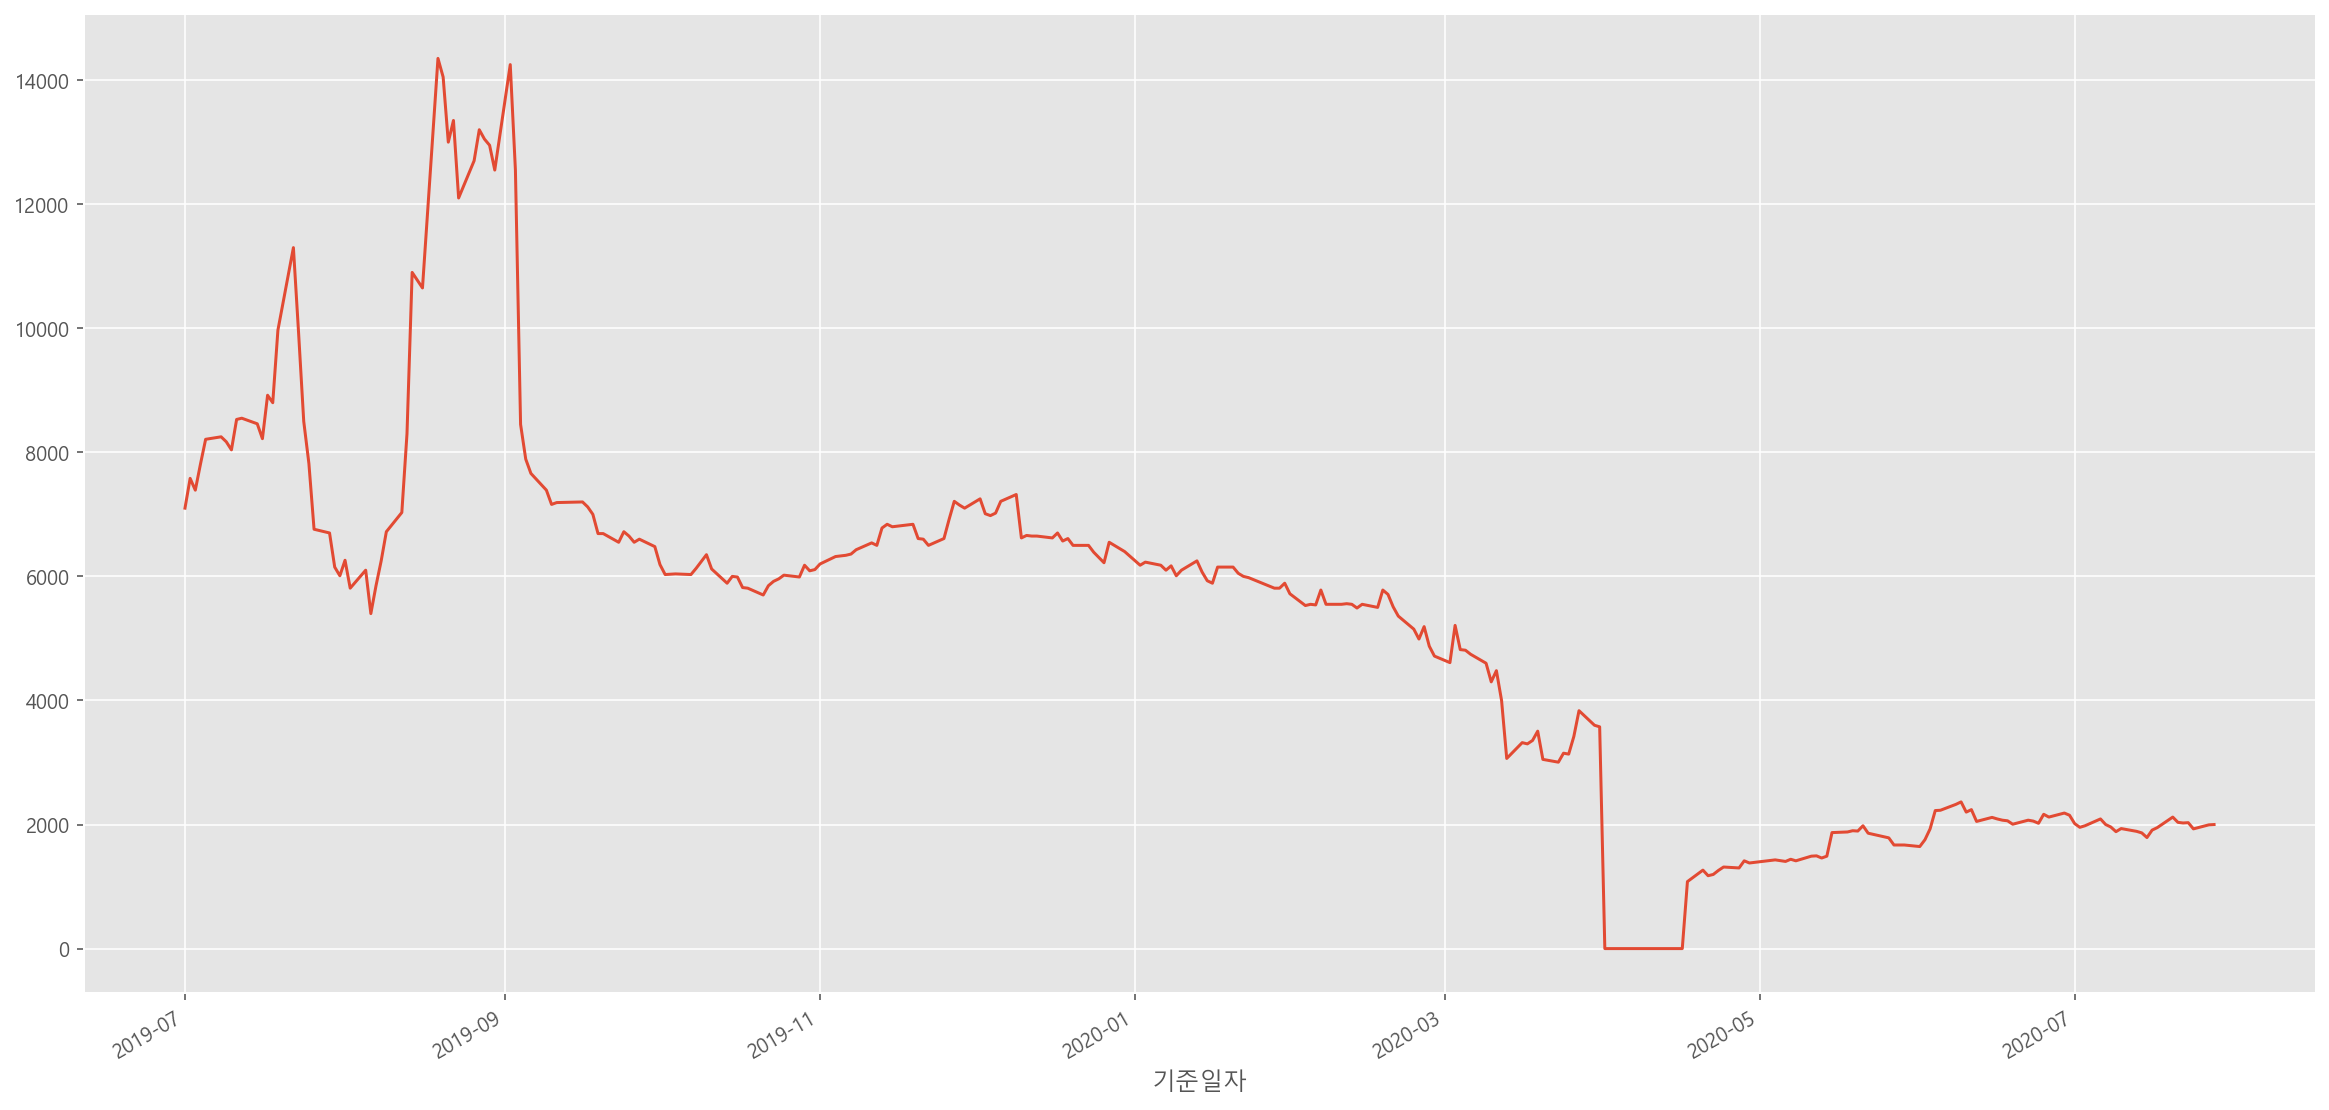

In [7]:
event_plot('A123010','종목시가',data_stocks)

## trade_train data 불러오기

In [8]:
data_train=pd.read_csv('./data/trade_train.csv',index_col=0)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 0 to 30199
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   기준년월      30200 non-null  int64 
 1   그룹번호      30200 non-null  object
 2   그룹내고객수    30200 non-null  int64 
 3   종목번호      30200 non-null  object
 4   그룹내_매수여부  30200 non-null  object
 5   그룹내_매도여부  30200 non-null  object
 6   매수고객수     30200 non-null  int64 
 7   매도고객수     30200 non-null  int64 
 8   평균매수수량    30200 non-null  int64 
 9   평균매도수량    30200 non-null  int64 
 10  매수가격_중앙값  30200 non-null  int64 
 11  매도가격_중앙값  30200 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.0+ MB


### data_train data 시계열로 변환 / 시각화

In [9]:
def train_plot(e,g,w,d):
    yearmonth_list = d['기준년월'].sort_values().unique().tolist()
    plot_df = d[(d['그룹번호']==g)&(d['종목번호']==e)][['기준년월',w]]
    val_list = [0]*len(yearmonth_list)
    for i in range(len(yearmonth_list)):
        try:
            val_list[i] = plot_df[plot_df['기준년월']==yearmonth_list[i]]['매수고객수'].tolist()[0]
        except:
            val_list[i] = 0
    plot_df_temp = pd.DataFrame(val_list)
    plot_df_temp.index = plot_df['기준년월'].apply(lambda x:str(x))
    
    plt.figure(figsize=(20,10))
    plot_df_temp[0].plot()
    plt.show()

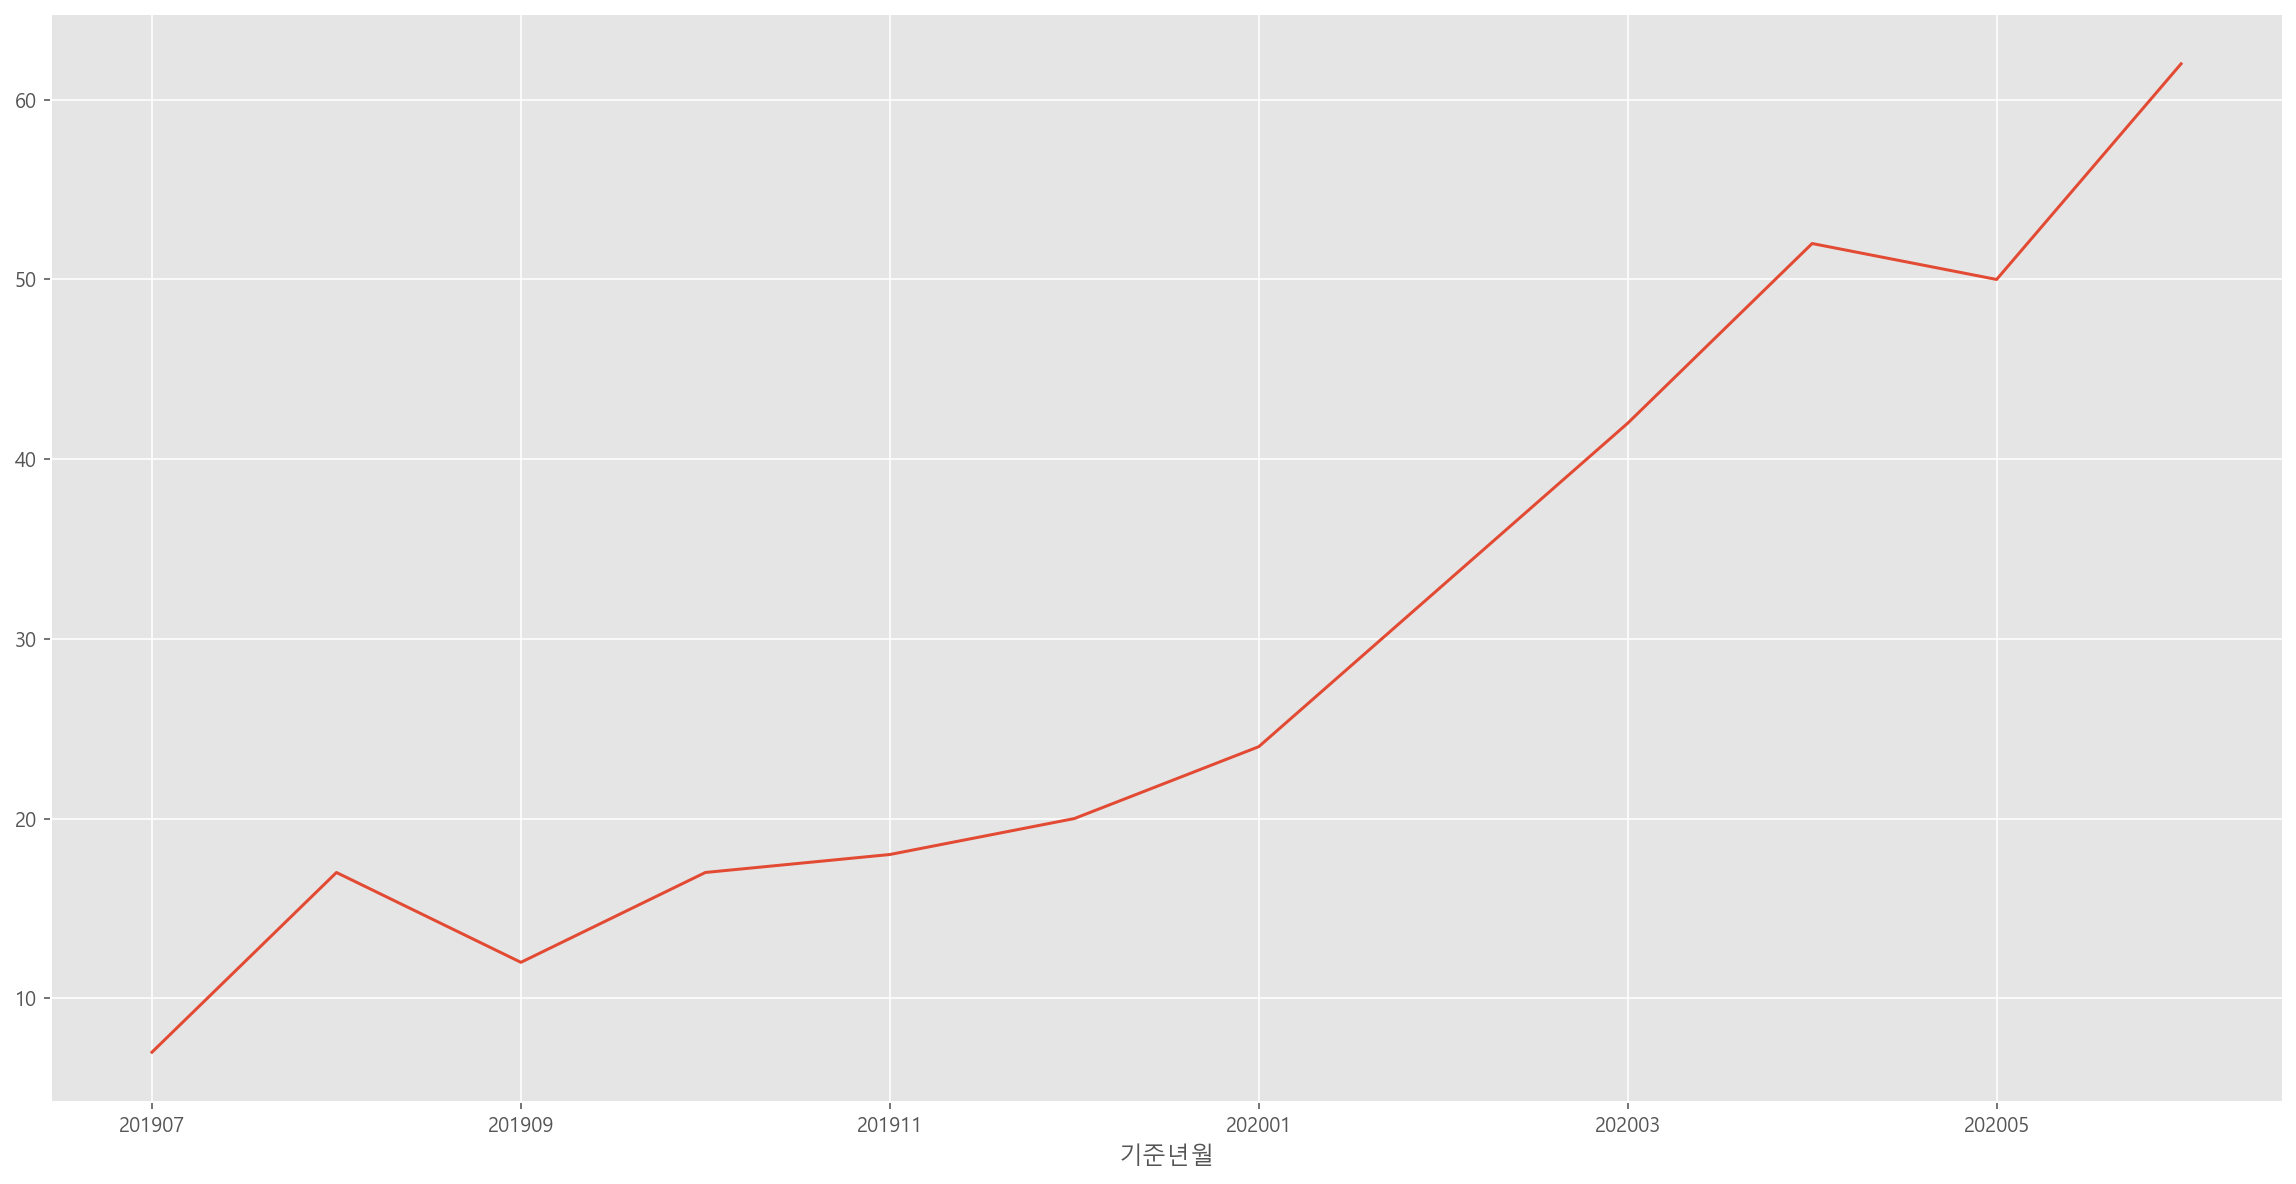

In [10]:
# 종목번호, 그룹명, 보고싶은 컬럼명, data_train
train_plot('A000660','MAD01','매수고객수',data_train)

# Answer Sheet

In [11]:
data_answer=pd.read_csv('./data/answer_sheet.csv')
data_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   그룹명     48 non-null     object
 1   종목번호1   48 non-null     object
 2   종목번호2   48 non-null     object
 3   종목번호3   48 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB


### Answer_sheet의 코스피/코스닥 비중

In [12]:
df=pd.DataFrame(data_stocks[data_stocks['20년7월TOP3대상여부']=='Y']['종목명'].unique())
df.columns=['종목명']
cos1=[]
for i in range(len(df['종목명'])):
    cos1.append(data_stocks[data_stocks['종목명']==df['종목명'][i]]['시장구분'].unique()[0])
    
collections.Counter(cos1)

Counter({'코스피': 61, '코스닥': 74})

### Answer_sheet의 표준산업구분코드_중분류

In [13]:
df=pd.DataFrame(data_stocks[data_stocks['20년7월TOP3대상여부']=='Y']['종목명'].unique())
df.columns=['종목명']
cos2=[]
for i in range(len(df['종목명'])):
    cos2.append(data_stocks[data_stocks['종목명']==df['종목명'][i]]['표준산업구분코드_중분류'].unique()[0])
    
cos2=collections.Counter(cos2)
cos2=[(l,k) for k,l in sorted([(j,i) for i,j in cos2.items()], reverse=True)]
cos2

[('통신장비 제조업', 15),
 ('도매 및 상품 중개업', 13),
 ('의료용 물질 및 의약품 제조업', 12),
 ('기타 기계 및 장비 제조업', 10),
 ('금융업', 8),
 ('출판업', 7),
 ('의약품 제외', 7),
 ('전자부품· 컴퓨터· 영상· 음향 및', 5),
 ('정보서비스업', 4),
 ('자동차 및 트레일러 제조업', 4),
 ('영상·오디오 기록물 제작 및 배급업', 4),
 ('식료품 제조업', 4),
 ('컴퓨터 프로그래밍· 시스템 통합 및 관리업', 3),
 ('전기장비 제조업', 3),
 ('의료· 정밀· 광학기기 및 시계 제조업', 3),
 ('우편 및 통신업', 3),
 ('소매업; 자동차 제외', 3),
 ('화학물질 및 화학제품 제조업;', 2),
 ('코크스· 연탄 및 석유정제품 제조업', 2),
 ('전문직별 공사업', 2),
 ('연구개발업', 2),
 ('비금속 광물제품 제조업', 2),
 ('기타 운송장비 제조업', 2),
 ('금융 및 보험 관련 서비스업', 2),
 ('고무 및 플라스틱제품 제조업', 2),
 ('항공 운송업', 1),
 ('펄프· 종이 및 종이제품 제조업', 1),
 ('종합 건설업', 1),
 ('전기· 가스· 증기 및 공기조절 공급업', 1),
 ('의복· 의복액세서리 및 모피제품', 1),
 ('방송업', 1),
 ('기타 제품 제조업', 1),
 ('기타 개인 서비스업', 1),
 ('금속가공제품 제조업;기계 및', 1),
 ('교육 서비스업', 1),
 ('1차 금속 제조업', 1)]

## Answer_sheet_to_csv

In [14]:
# ans_list = [data_answer[['그룹명','종목번호'+str(i)]] for i in range(1,4)]
# for i in range(3):
#     ans_list[i].columns = ['그룹명','종목번호']
# ans = pd.concat(ans_list)
# ans = ans.sort_values('그룹명').copy()
# ans.index = range(len(ans))
# col = data_stocks.columns[2:8].tolist()
# temp = data_stocks[data_stocks['종목번호']==ans.iloc[0,1]][col].drop_duplicates()
# for i in range(1,len(ans)):
#     temp = pd.concat([temp,data_stocks[data_stocks['종목번호']==ans.iloc[i,1]][col].drop_duplicates()])
# temp.index = range(len(temp))
# for i in col:
#     ans[i] = temp[i]
    
# ans.to_csv('answer_to_csv.csv',encoding='euc-kr')

In [15]:
data_train['그룹내고객수'].unique()

array([ 288,  112,  250,  776,  890, 1615,   86,  386,  634,  106,  175,
        152,  167,  253,  104,  102,  286,  545,  140,  143,  637,   97,
       1724,   87,  103,  249,  153,  115,  116,   84,  150,  320,   92,
        769,  251,  366,  608,   91,  932,  444, 2879,  264,  204,  684,
        244,  163,   82], dtype=int64)

## 누락 데이터 처리
* MAD03에서 A204990 종목데이터를 없애준다 / A204990=코썬바이오 : 상장폐지 되어 유실 된 데이터

In [16]:
data_train[data_train['종목번호']=='A204990']

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
2398,201908,MAD35,769,A204990,Y,Y,3,3,841,771,2510,2445
2505,201908,MAD38,608,A204990,Y,Y,3,3,932,932,2230,2317
2758,201908,MAD42,444,A204990,Y,Y,5,5,1167,1214,2385,2265
3005,201909,MAD03,250,A204990,Y,Y,4,4,724,704,3955,3983
3249,201909,MAD06,1615,A204990,Y,Y,3,3,1344,1344,4638,4652
3309,201909,MAD08,386,A204990,Y,Y,4,4,4259,5678,3897,3969
3981,201909,MAD41,932,A204990,Y,Y,9,8,813,739,3854,3872
4084,201909,MAD42,444,A204990,Y,Y,3,3,1721,1663,3820,3820
5560,201910,MAD41,932,A204990,Y,Y,4,3,2270,2169,2417,2410
8781,201912,MAD41,932,A204990,Y,Y,4,4,1284,1158,1300,1295


In [17]:
data_train=data_train.drop(data_train[data_train['종목번호']=='A204990'].index)

In [18]:
data_train[data_train['종목번호']=='A204990']

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


## 48개의 그룹 변수 생성하고 표준사업분류코드 추출

In [19]:
for i in range(1,49):
    if i<=9:
        globals()['m{}'.format(i)]=data_train[data_train['그룹번호']=='MAD0'+str(i)]
    else:
        globals()['m{}'.format(i)]=data_train[data_train['그룹번호']=='MAD'+str(i)]

In [20]:
# m_num = [i['종목번호'].sort_values().unique().tolist() for i in m]
# group_list = new_data_train['그룹번호'].sort_values().unique().tolist()
# m = [new_data_train[new_data_train['그룹번호']==i] for i in group_list]
# gp = [data_stocks[data_stocks['종목번호'].apply(lambda x: x in m_num[i])]
#  [['종목번호','표준산업구분코드_대분류']].drop_duplicates("종목번호")['표준산업구분코드_대분류']
#  for i in range(len(m_num))
# ]
# gp = [gp[i].tolist() for i in range(len(gp))]
# collections.Counter(gp[0])

In [21]:
for i in range(1,49):
    globals()['m{}_num'.format(i)]=globals()['m{}'.format(i)]['종목번호'].unique()
    globals()['gp{}'.format(i)]=[]
    for j in range(len(globals()['m{}_num'.format(i)])):
        globals()['gp{}'.format(i)].append(data_stocks[data_stocks['종목번호']==globals()['m{}_num'.format(i)][j]]['표준산업구분코드_대분류'].unique()[0])

In [22]:
gp1

['제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '도매 및 소매업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '전문· 과학 및 기술 서비스업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '전문· 과학 및 기술 서비스업',
 '제조업',
 '제조업',
 '제조업',
 '전문· 과학 및 기술 서비스업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '전기· 가스· 증기 및 공기조절 공급업',
 '제조업',
 '서비스업',
 '정보통신업',
 '사업시설관리 및 사업지원 및 임대 서비스업',
 '제조업',
 '정보통신업',
 '정보통신업',
 '제조업',
 '제조업',
 '제조업',
 '운수 및 창고업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '건설업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '정보통신업',
 '도매 및 소매업',
 '도매 및 소매업',
 '정보통신업',
 '제조업',
 '제조업',
 '제조업',
 '정보통신업',
 '금융 및 보험업',
 '정보통신업',
 '제조업',
 '정보통신업',
 '제조업',
 '제조업',
 '금융 및 보험업',
 '제조업',
 '제조업',
 '제조업',
 '금융 및 보험업',
 '제조업',
 '운수 및 창고업',
 '전기· 가스· 증기 및 공기조절 공급업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업',
 '제조업']

### 표준산업구분코드_대분류를 종류별로 Count

In [23]:
for i in range(1,49):
    globals()['counter{}'.format(i)]=collections.Counter(globals()['gp{}'.format(i)])
    globals()['counter{}'.format(i)]=[(l,k) for k,l in sorted([(j,i) for i,j in globals()['counter{}'.format(i)].items()], reverse=True)]
    globals()['counter{}'.format(i)]

In [24]:
counter1

[('제조업', 65),
 ('정보통신업', 8),
 ('전문· 과학 및 기술 서비스업', 3),
 ('도매 및 소매업', 3),
 ('금융 및 보험업', 3),
 ('전기· 가스· 증기 및 공기조절 공급업', 2),
 ('운수 및 창고업', 2),
 ('서비스업', 1),
 ('사업시설관리 및 사업지원 및 임대 서비스업', 1),
 ('건설업', 1)]

## Answer_sheet의 종목코드 -> 표준산업구분코드_대분류

In [25]:
for i in range(1,49):
    globals()['data_answer_{}'.format(i)]=[]
    if i<=9:
        for j in range(1,4):
            globals()['data_answer_{}'.format(i)].append(data_answer[data_answer['그룹명']=='MAD0'+str(i)]['종목번호'+str(j)][i-1])
    else:
        for j in range(1,4):
            globals()['data_answer_{}'.format(i)].append(data_answer[data_answer['그룹명']=='MAD'+str(i)]['종목번호'+str(j)][i-1])

In [26]:
data_answer_1

['A000990', 'A052900', 'A123010']

In [27]:
for i in range(1,49):
    globals()['data_make_{}'.format(i)]=[]
    for j in range(3):
        globals()['data_make_{}'.format(i)].append(data_stocks[data_stocks['종목번호']==globals()['data_answer_{}'.format(i)][j]]['표준산업구분코드_대분류'].unique()[0])

In [28]:
data_make_1

['제조업', '제조업', '제조업']

# Counter <-> data_make

In [29]:
ik = [0]*48
for i in range(1,49):
    ik[i-1] = globals()['counter{}'.format(i)],globals()['data_make_{}'.format(i)]

In [30]:
ik1 = [ik[i][0] for i in range(48)]
ik2 = [ik[i][1] for i in range(48)]

In [31]:
df1 = pd.DataFrame(ik1)

In [32]:
df2 = pd.DataFrame(ik2)

In [33]:
df1['temp1'] = df2[0]
df1['temp2'] = df2[1]
df1['temp3'] = df2[2]

In [34]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,temp1,temp2,temp3
0,"(제조업, 65)","(정보통신업, 8)","(전문· 과학 및 기술 서비스업, 3)","(도매 및 소매업, 3)","(금융 및 보험업, 3)","(전기· 가스· 증기 및 공기조절 공급업, 2)","(운수 및 창고업, 2)","(서비스업, 1)","(사업시설관리 및 사업지원 및 임대 서비스업, 1)","(건설업, 1)",None,None,None,None,제조업,제조업,제조업
1,"(제조업, 19)","(정보통신업, 5)","(운수 및 창고업, 4)","(도매 및 소매업, 4)","(금융 및 보험업, 4)","(전문· 과학 및 기술 서비스업, 2)","(건설업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)",None,None,None,None,None,None,제조업,제조업,금융 및 보험업
2,"(제조업, 178)","(정보통신업, 29)","(도매 및 소매업, 19)","(전문· 과학 및 기술 서비스업, 17)","(금융 및 보험업, 10)","(운수 및 창고업, 5)","(건설업, 4)","(교육 서비스업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(예술· 스포츠 및 여가관련, 1)","(수도· 하수 및 폐기물 처리· 원료 재생업, 1)","(서비스업, 1)",None,None,제조업,제조업,정보통신업
3,"(제조업, 309)","(정보통신업, 55)","(도매 및 소매업, 34)","(금융 및 보험업, 25)","(전문· 과학 및 기술 서비스업, 21)","(운수 및 창고업, 9)","(건설업, 7)","(서비스업, 3)","(교육 서비스업, 3)","(수도· 하수 및 폐기물 처리· 원료 재생업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(예술· 스포츠 및 여가관련, 1)",None,None,제조업,제조업,제조업
4,"(제조업, 330)","(정보통신업, 75)","(도매 및 소매업, 43)","(금융 및 보험업, 27)","(전문· 과학 및 기술 서비스업, 26)","(운수 및 창고업, 12)","(건설업, 6)","(수도· 하수 및 폐기물 처리· 원료 재생업, 4)","(서비스업, 3)","(교육 서비스업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(예술· 스포츠 및 여가관련, 1)","(사업시설관리 및 사업지원 및 임대 서비스업, 1)","(개인 서비스업, 1)",제조업,제조업,제조업
5,"(제조업, 517)","(정보통신업, 103)","(도매 및 소매업, 58)","(금융 및 보험업, 34)","(전문· 과학 및 기술 서비스업, 31)","(운수 및 창고업, 17)","(건설업, 13)","(수도· 하수 및 폐기물 처리· 원료 재생업, 4)","(교육 서비스업, 4)","(서비스업, 3)","(전기· 가스· 증기 및 공기조절 공급업, 2)","(예술· 스포츠 및 여가관련, 2)","(사업시설관리 및 사업지원 및 임대 서비스업, 1)","(개인 서비스업, 1)",건설업,제조업,제조업
6,"(제조업, 33)","(전문· 과학 및 기술 서비스업, 2)","(도매 및 소매업, 2)","(정보통신업, 1)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(운수 및 창고업, 1)",None,None,None,None,None,None,None,None,제조업,제조업,제조업
7,"(제조업, 284)","(정보통신업, 49)","(도매 및 소매업, 34)","(전문· 과학 및 기술 서비스업, 24)","(운수 및 창고업, 11)","(금융 및 보험업, 11)","(건설업, 8)","(수도· 하수 및 폐기물 처리· 원료 재생업, 3)","(서비스업, 2)","(교육 서비스업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(예술· 스포츠 및 여가관련, 1)","(사업시설관리 및 사업지원 및 임대 서비스업, 1)",None,도매 및 소매업,도매 및 소매업,건설업
8,"(제조업, 288)","(정보통신업, 60)","(도매 및 소매업, 35)","(금융 및 보험업, 25)","(전문· 과학 및 기술 서비스업, 22)","(운수 및 창고업, 11)","(건설업, 6)","(서비스업, 4)","(교육 서비스업, 2)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(예술· 스포츠 및 여가관련, 1)","(수도· 하수 및 폐기물 처리· 원료 재생업, 1)","(사업시설관리 및 사업지원 및 임대 서비스업, 1)",None,제조업,금융 및 보험업,금융 및 보험업
9,"(제조업, 10)","(정보통신업, 4)","(전기· 가스· 증기 및 공기조절 공급업, 1)","(금융 및 보험업, 1)",None,None,None,None,None,None,None,None,None,None,제조업,제조업,제조업


In [35]:
data_train['그룹내고객수'].unique()

array([ 288,  112,  250,  776,  890, 1615,   86,  386,  634,  106,  175,
        152,  167,  253,  104,  102,  286,  545,  140,  143,  637,   97,
       1724,   87,  103,  249,  153,  115,  116,   84,  150,  320,   92,
        769,  251,  366,  608,   91,  932,  444, 2879,  264,  204,  684,
        244,  163,   82], dtype=int64)

### answer_sheet의 표준산업구분코드_대분류 count

In [36]:
make_list=[]
for i in range(1,49):
    for j in range(3):
        make_list.append(globals()['data_make_{}'.format(i)][j])

In [37]:
counter_list=collections.Counter(make_list)
counter_list

Counter({'제조업': 87,
         '금융 및 보험업': 14,
         '정보통신업': 18,
         '건설업': 5,
         '도매 및 소매업': 15,
         '운수 및 창고업': 1,
         '전문· 과학 및 기술 서비스업': 2,
         '전기· 가스· 증기 및 공기조절 공급업': 1,
         '교육 서비스업': 1})

### data_stocks의 표준산업구분코드_대분류 count

In [38]:
collections.Counter(data_stocks['표준산업구분코드_대분류'])

Counter({'제조업': 185875,
         '운수 및 창고업': 5517,
         '금융 및 보험업': 14107,
         '전문· 과학 및 기술 서비스업': 10496,
         '건설업': 5628,
         '도매 및 소매업': 21172,
         '정보통신업': 37102,
         '전기· 가스· 증기 및 공기조절 공급업': 536,
         '개인 서비스업': 268,
         '수도· 하수 및 폐기물 처리· 원료 재생업': 1608,
         '예술· 스포츠 및 여가관련': 536,
         '서비스업': 1340,
         '교육 서비스업': 1072,
         '사업시설관리 및 사업지원 및 임대 서비스업': 804})

## MAD 그룹을 분석해보자

In [39]:
pd.set_option('display.max_rows', 220)

### 그룹의 answer_sheet 확인

In [40]:
data_answer.loc[20]

그룹명        MAD21
종목번호1    A096530
종목번호2    A239340
종목번호3    A248170
Name: 20, dtype: object

### 그룹의 구매 주식 종목번호

In [163]:
data_train[data_train['그룹번호']=='MAD47']['그룹내고객수'].unique()[0]

244

In [181]:
mad[43]

['SK하이닉스',
 '삼성전자',
 '삼성전자우',
 '미래에셋대우',
 '삼성전기',
 'SOil',
 '후성',
 'KB금융',
 '미래에셋대우2우B',
 'SK',
 'LG전자',
 '마니커',
 '신한지주',
 '하나금융지주',
 'LG화학',
 '엑사이엔씨',
 '헬릭스미스',
 '신라젠',
 '현대차우',
 'NH투자증권',
 '현대차',
 '고려아연',
 '한국전력',
 '애경산업',
 '기업은행',
 'LG디스플레이',
 '오공',
 'LG생활건강',
 '셀트리온',
 '아모레퍼시픽',
 'SK이노베이션',
 '스튜디오드래곤',
 '대한항공',
 'LG',
 'POSCO',
 '삼성SDI',
 'LG이노텍',
 '현대모비스',
 '삼성증권',
 'SK텔레콤',
 'LG유플러스',
 '카카오',
 '미코',
 '셀트리온헬스케어',
 '씨젠',
 'RFHIC',
 '우리금융지주',
 '파미셀',
 '녹십자',
 '남선알미늄',
 '삼성물산',
 '초록뱀',
 '이마트',
 '두산솔루스',
 '두산',
 '제일기획',
 '종근당',
 '대림산업',
 '기아차',
 'SK증권',
 '부광약품',
 '포스코케미칼',
 '신세계',
 '삼성중공업',
 '롯데케미칼',
 '팬오션',
 '케이엠더블유',
 '대우조선해양',
 'SK바이오랜드',
 '빅텍',
 '삼성바이오로직스',
 '넷마블']

In [193]:
data_train[data_train['그룹번호']=='MAD45']['매수고객수'].sort_values().unique()

array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19, 20,
       21, 24, 25, 28, 33, 43], dtype=int64)

In [199]:
a=data_train[(data_train['매수고객수']==24)&(data_train['그룹번호']=='MAD45')]
b=a['종목번호'].to_list()
data_stocks[data_stocks['종목번호']==b[0]]['종목명'].unique()[0], b

('NAVER', ['A035420'])

### 그 그룹이 산 주식 거래 내역

In [201]:
data_train[(data_train['종목번호']=='A035420')&(data_train['그룹번호']=='MAD45')]

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
16881,202003,MAD45,204,A035420,Y,Y,5,6,86,89,163500,160000
21094,202004,MAD45,204,A035420,Y,Y,7,8,10,27,169000,178000
25075,202005,MAD45,204,A035420,Y,Y,17,9,31,4,223374,221750
29926,202006,MAD45,204,A035420,Y,Y,24,21,83,72,242500,244000


In [45]:
data_stocks[data_stocks['종목명']=='KT서브마린'].tail(30)

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
index,,,,,,,,,,,,,,
253976,20200617,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4035,4125,3950,4035,133849,53962
255062,20200618,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4050,4560,3940,4100,3212084,1395836
256148,20200619,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4120,4300,4010,4110,452132,186635
257234,20200622,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4150,4160,4065,4110,155116,63633
258321,20200623,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4150,4160,4000,4055,165943,67268
259408,20200624,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4090,4125,4050,4080,163594,66806
260495,20200625,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4020,4105,4000,4070,135250,54735
261582,20200626,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4100,4195,4035,4130,219611,90111
262669,20200629,A060370,KT서브마린,Y,코스닥,건설업,전문직별 공사업,전기 및 통신 공사업,4080,4185,4035,4120,267298,110260


In [46]:
data_stocks[data_stocks['종목명']=='신라젠'].tail(1)

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
index,,,,,,,,,,,,,,
285883,20200728,A215600,신라젠,N,코스닥,전문· 과학 및 기술 서비스업,연구개발업,자연과학 및 공학 연구개발업,0,0,0,12100,0,0


### 주식 거래 내역 그래프

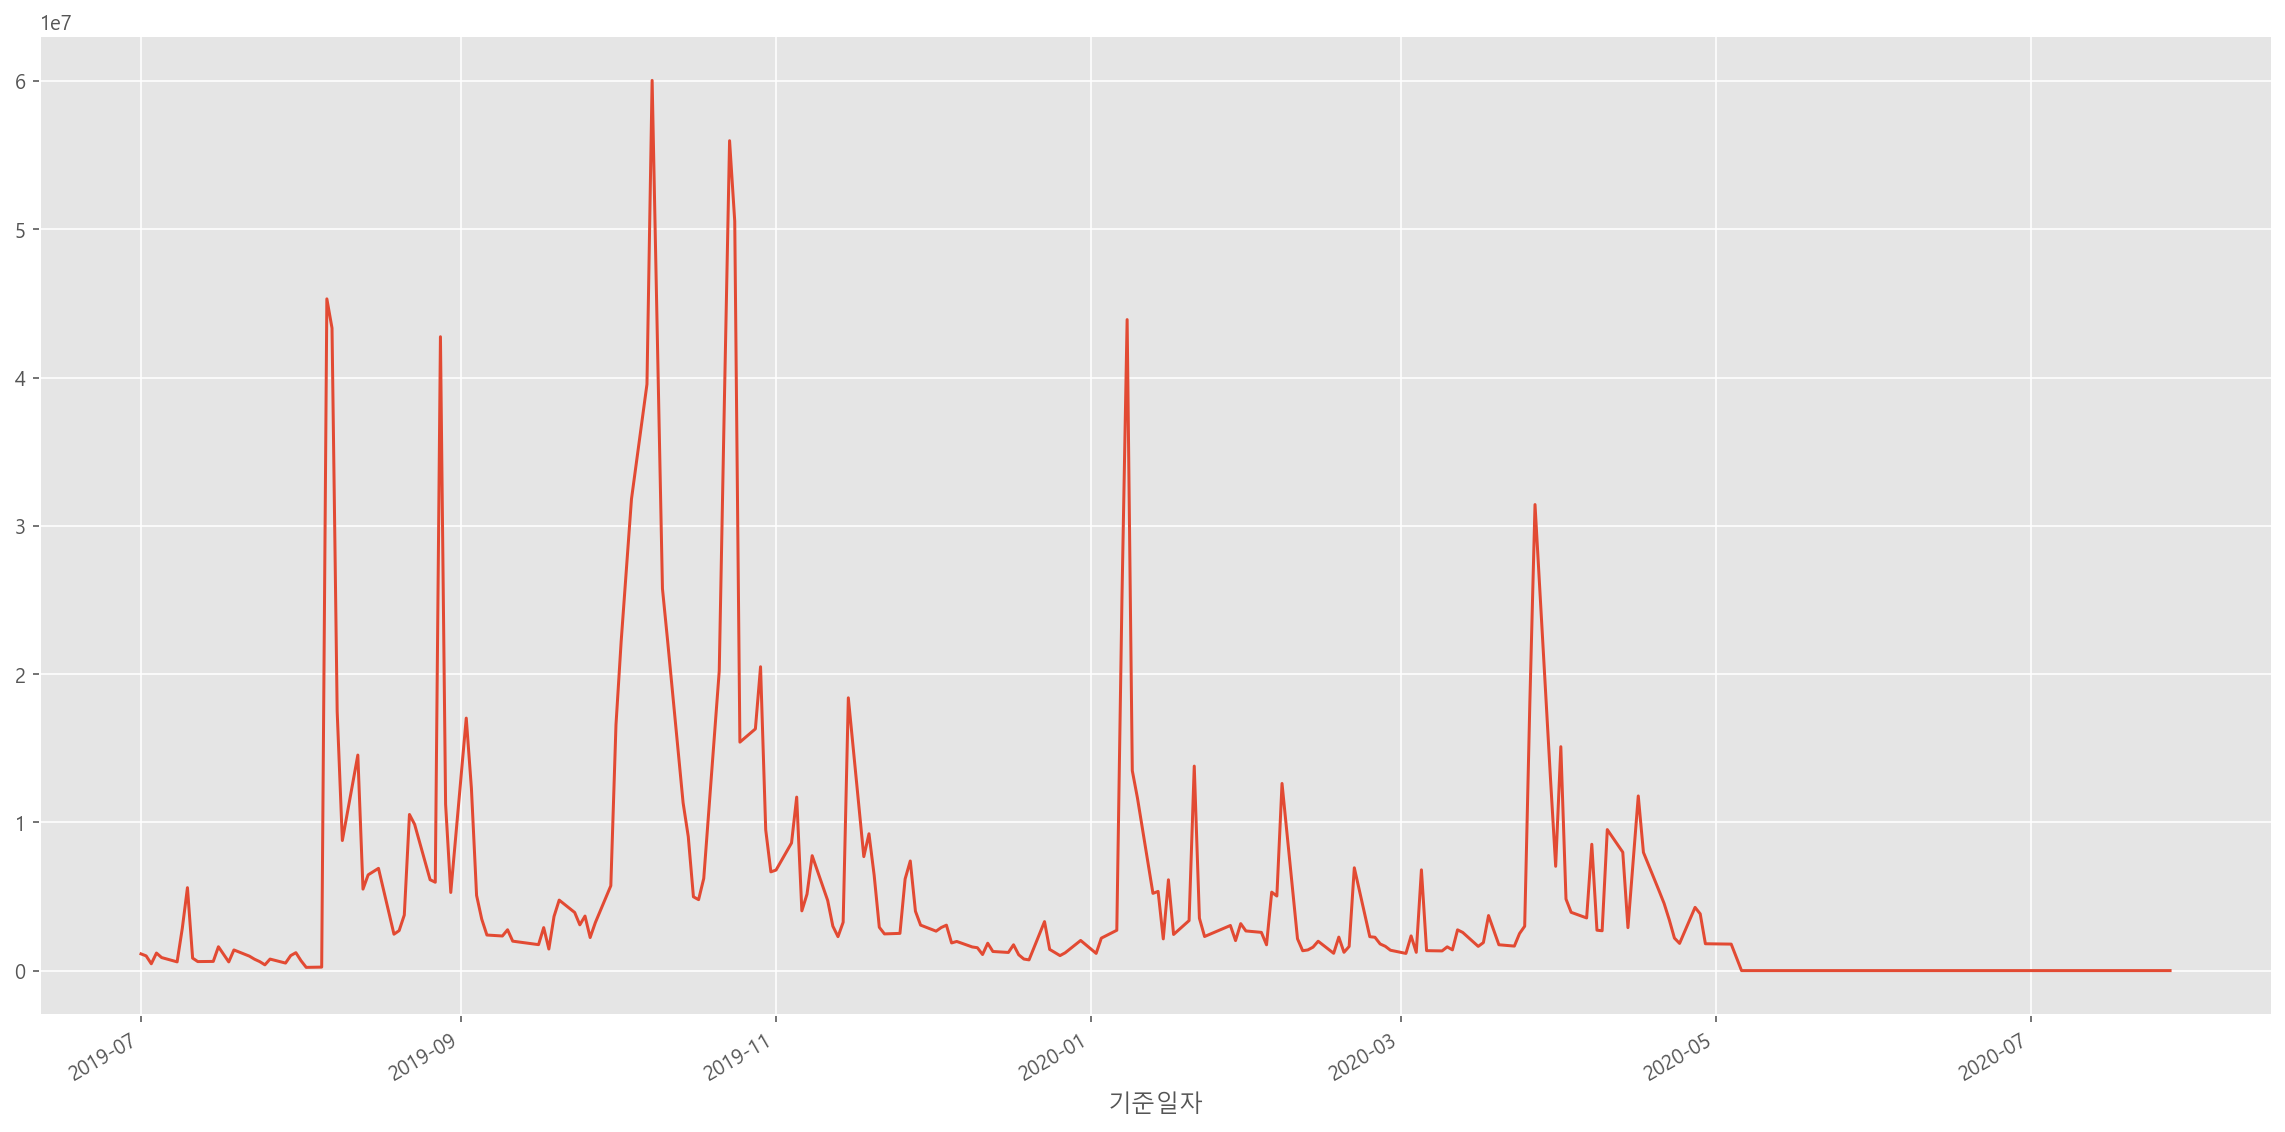

In [47]:
event_plot('A215600','거래량',data_stocks)

### 그룹별 구매 표준산업구분코드_대분류 그룹핑

In [48]:
counter48

[('제조업', 46),
 ('정보통신업', 11),
 ('금융 및 보험업', 10),
 ('도매 및 소매업', 5),
 ('전문· 과학 및 기술 서비스업', 3),
 ('운수 및 창고업', 3),
 ('전기· 가스· 증기 및 공기조절 공급업', 1),
 ('건설업', 1)]

### 그룹별 구매 표준산업구분코드_중분류 그룹핑

In [49]:
gp_2=[]
for j in range(len(m2_num)):
    gp_2.append(data_stocks[data_stocks['종목번호']==m2_num[j]]['표준산업구분코드_중분류'].unique()[0])

gp_2

mid_counter_2=collections.Counter(gp_2)
mid_counter_2=[(l,k) for k,l in sorted([(j,i) for i,j in mid_counter_2.items()], reverse=True)]
mid_counter_2

[('통신장비 제조업', 5),
 ('항공 운송업', 3),
 ('의료용 물질 및 의약품 제조업', 3),
 ('화학물질 및 화학제품 제조업;', 2),
 ('종합 건설업', 2),
 ('정보서비스업', 2),
 ('자동차 및 트레일러 제조업', 2),
 ('영상·오디오 기록물 제작 및 배급업', 2),
 ('소매업; 자동차 제외', 2),
 ('도매 및 상품 중개업', 2),
 ('기타 운송장비 제조업', 2),
 ('기타 기계 및 장비 제조업', 2),
 ('금융업', 2),
 ('코크스· 연탄 및 석유정제품 제조업', 1),
 ('전자부품· 컴퓨터· 영상· 음향 및', 1),
 ('전문서비스업', 1),
 ('전기장비 제조업', 1),
 ('전기· 가스· 증기 및 공기조절 공급업', 1),
 ('육상운송 및 파이프라인 운송업', 1),
 ('우편 및 통신업', 1),
 ('연구개발업', 1),
 ('보험 및 연금업', 1),
 ('금융 및 보험 관련 서비스업', 1)]

### 그룹의 거래주식 종목명

In [50]:
group_list = sorted(data_train['그룹번호'].unique().tolist())
mad = []
for i in group_list:
    mad.append(data_train[data_train['그룹번호']==i]['종목번호'].drop_duplicates().apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2]).tolist())
    print("\r",i,end='')

 MAD48

## 종목이 있는 그룹

In [51]:
for i in group_list:
    print(i)
    display(data_train[(data_train['그룹번호']==i)&(data_train['종목번호']==data_stocks[data_stocks['종목명']=='시노펙스']['종목번호'].unique()[0])])

MAD01


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD02


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD03


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD04


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
17233,202004,MAD04,776,A025320,Y,Y,7,10,299,521,3215,3140


MAD05


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
17403,202004,MAD05,890,A025320,Y,Y,5,3,194,174,2805,2495
25719,202006,MAD05,890,A025320,Y,Y,4,3,722,509,3090,2888


MAD06


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
1753,201908,MAD06,1615,A025320,Y,Y,3,4,74,119,3537,3457
17660,202004,MAD06,1615,A025320,Y,Y,7,9,1992,1929,3469,2825


MAD07


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD08


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
1875,201908,MAD08,386,A025320,Y,Y,4,4,6367,6367,3266,3243
17970,202004,MAD08,386,A025320,Y,Y,9,5,755,361,2951,3330


MAD09


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
1934,201908,MAD09,634,A025320,Y,Y,3,3,520,520,3465,3455
18140,202004,MAD09,634,A025320,Y,Y,7,8,857,1281,3263,3320
26513,202006,MAD09,634,A025320,Y,Y,3,3,1865,4707,3201,2955


MAD10


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD11


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD12


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD13


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD14


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
18364,202004,MAD14,253,A025320,Y,Y,3,4,607,732,2665,2690


MAD15


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD16


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD17


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD18


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD19


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD20


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD21


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
18698,202004,MAD21,637,A025320,Y,Y,6,8,1052,1073,3396,3382


MAD22


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD23


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
2158,201908,MAD23,1724,A025320,Y,Y,4,5,875,859,2385,2335
18904,202004,MAD23,1724,A025320,Y,Y,8,8,2098,2305,2852,2801
23030,202005,MAD23,1724,A025320,Y,Y,3,4,1027,2570,2880,2900
27434,202006,MAD23,1724,A025320,Y,Y,5,6,457,1248,3031,3030


MAD24


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD25


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD26


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD27


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD28


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD29


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
2273,201908,MAD29,115,A025320,Y,Y,3,4,637,578,2480,2387
19254,202004,MAD29,115,A025320,Y,Y,4,3,1994,1944,2404,2482
23388,202005,MAD29,115,A025320,Y,Y,4,5,5703,2330,2935,2977


MAD30


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD31


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD32


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
19419,202004,MAD32,150,A025320,Y,Y,6,6,1316,1996,3435,2722
28070,202006,MAD32,150,A025320,Y,Y,4,5,533,446,2970,2925


MAD33


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD34


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD35


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
19622,202004,MAD35,769,A025320,Y,Y,6,6,1879,1905,3528,3341


MAD36


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD37


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD38


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
2472,201908,MAD38,608,A025320,Y,Y,3,3,192,197,2365,2275
19938,202004,MAD38,608,A025320,Y,Y,6,4,1933,1710,3217,3224


MAD39


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD40


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD41


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
1060,201907,MAD41,932,A025320,Y,Y,6,6,1473,1473,2468,2483
2570,201908,MAD41,932,A025320,Y,Y,5,6,1186,1159,3311,3309
20212,202004,MAD41,932,A025320,Y,Y,22,25,3140,3182,3213,3232
28973,202006,MAD41,932,A025320,Y,Y,8,10,3146,4038,3214,3131


MAD42


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
2714,201908,MAD42,444,A025320,Y,Y,4,5,482,1470,3365,3491
20525,202004,MAD42,444,A025320,Y,Y,15,10,4997,3065,2746,2626
24552,202005,MAD42,444,A025320,Y,Y,6,4,3580,1642,2990,3030
29312,202006,MAD42,444,A025320,Y,Y,3,4,752,1515,3203,2956


MAD43


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
20797,202004,MAD43,2879,A025320,Y,Y,13,12,285,264,3125,3245


MAD44


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD45


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD46


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD47


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


MAD48


,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값


### 그룹의 코스피/코스닥 거래 비중

In [52]:
cos_by_1=[]
for i in range(len(mad[0])):
    cos_by_1.append(data_stocks[data_stocks['종목명']==mad[0][i]]['시장구분'].unique()[0])
    
collections.Counter(cos_by_1)

Counter({'코스피': 60, '코스닥': 29})

In [53]:
mid_mad48=[]
for i in range(len(mad[47])):
    mid_mad48.append(data_stocks[data_stocks['종목명']==mad[47][i]]['표준산업구분코드_중분류'].unique()[0])

mid_mad48=collections.Counter(mid_mad48)
mid_mad48=[(l,k) for k,l in sorted([(j,i) for i,j in mid_mad48.items()], reverse=True)]
mid_mad48

[('의료용 물질 및 의약품 제조업', 8),
 ('의약품 제외', 6),
 ('금융업', 6),
 ('화학물질 및 화학제품 제조업;', 5),
 ('통신장비 제조업', 5),
 ('출판업', 5),
 ('전기장비 제조업', 4),
 ('자동차 및 트레일러 제조업', 4),
 ('펄프· 종이 및 종이제품 제조업', 3),
 ('소매업; 자동차 제외', 3),
 ('기타 운송장비 제조업', 3),
 ('금융 및 보험 관련 서비스업', 3),
 ('1차 금속 제조업', 3),
 ('항공 운송업', 2),
 ('코크스· 연탄 및 석유정제품 제조업', 2),
 ('정보서비스업', 2),
 ('우편 및 통신업', 2),
 ('연구개발업', 2),
 ('도매 및 상품 중개업', 2),
 ('컴퓨터 프로그래밍· 시스템 통합 및 관리업', 1),
 ('종합 건설업', 1),
 ('전자부품· 컴퓨터· 영상· 음향 및', 1),
 ('전기· 가스· 증기 및 공기조절 공급업', 1),
 ('의료· 정밀· 광학기기 및 시계 제조업', 1),
 ('수상 운송업', 1),
 ('보험 및 연금업', 1),
 ('방송업', 1),
 ('기타 기계 및 장비 제조업', 1),
 ('건축기술· 엔지니어링 및 기타', 1)]

In [54]:
print(data_train[data_train['그룹번호']=='MAD48']['그룹내고객수'].unique()[0]),
print(data_train[data_train['그룹번호']=='MAD48']['매수고객수'].sort_values().unique()[-1]),
a=data_train[(data_train['매수고객수']==data_train[data_train['그룹번호']=='MAD48']['매수고객수'].sort_values().unique()[-1])
             &(data_train['그룹번호']=='MAD48')]
b=a['종목번호'].to_list()
data_stocks[data_stocks['종목번호']==b[0]]['종목명'].unique()[0], b

163
33


('삼성전자', ['A005930'])

# 상장폐지& 거래정지
* ['흥아해운','메디앙스','디에스티','럭슬','에이프런티어', '솔브레인홀딩스', '팍스넷', '에이아이비트', '셀루메드', '이에스에이', '현진소재', '제낙스', '이노와이즈', '에스모머티리얼즈', '포티스', '이큐셀', '내츄럴엔도텍', '퓨전', '신라젠', '경남제약헬스케어', '샘코', '블러썸엠앤씨']
* 흥아해운, 디에스티, 제낙스-0330부터 X
* 메디앙스, 에이프런티어-0320
* 럭슬-0212
* 솔브레인홀딩스-0629
* 팍스넷, 이에스에이 0324
* 에이아이비트, 이큐셀 0323
* 셀루메드 	20191114
* 현진소재 - 0403
* 이노와이즈 0504
* 에스모머티리얼즈 0410
* 포티스 0313
* 신라젠 0506
* 경남제약헬스케어 0421
* 샘코 0323
* 블러썸엠앤씨 - 0529
* 퓨전 0407
* 내츄럴엔도텍 0217흥아해운, 디에스티, 제낙스-0330부터 X
* 메디앙스, 에이프런티어-0320
* 럭슬-0212
* 솔브레인홀딩스-0629
* 팍스넷, 이에스에이 0324
* 에이아이비트, 이큐셀 0323
* 셀루메드 	20191114
* 현진소재 - 0403
* 이노와이즈 0504
* 에스모머티리얼즈 0410
* 포티스 0313
* 신라젠 0506
* 경남제약헬스케어 0421
* 샘코 0323
* 블러썸엠앤씨 - 0529
* 퓨전 0407
* 내츄럴엔도텍 0217

* 20191205 A053950 경남제약  상장폐지->부활   이전데이터 삭제
* 20190821 A256840 한국비엔씨 상장폐지->부활 이전데이터 삭제
* 20190705, 10일 A023770 플레이위드 투자경고종목 지정: 데이터 삭제
* 20190711, 0812 A045890 GV 불성실공시법인 데이터 삭제
* 20190716, 1007 A053590 한국테크놀로지 우회상장여부
* 20190718-30 A036420 제이콘텐트리 구주권 제출로 거래정지 데이터 삭제/ 액면병합
* 20190719-0805 A215380 우정바이오 액면병합
* 20190725 A031860	 엔에스엔	 불성실
* 20190725 A222810	한류AI센터 꽤 많은데 그냥 삭제해도 됨, 풍문에 의한 거래정지
* 20200203-05 A002070 비비안 적격성 심사
* 20190806 A000145	하이트진로홀딩스우 투자위험 삭제	
* 20190806 A092190	서울바이오시스 투자위험 삭제
* 20190814 A208370	셀바스헬스케어 관리종목 위험
* 20190819 A302550	리메드 투자위험
* 20190823 A078590	OQP 삭제해도 됨
* 20190905-30 A025320 시노펙스-잘못함 이 데이터는 없애도 됨	
* 20190920-1004 A012340	뉴인텍	유상감자-데이터 없애자
* 20190924 A033250	체시스	투자 위험
* 20190926-1011	A208350	지란지교시큐리티 액면병합
* 20190927-1014	A000150	두산 인적분할-3개회사로
* 20191007-21	A001210	금호전기-액면분할, 근데 가격은 안변함!!
* 20191011-24	A281740	레이크머티리얼즈-흡수합병 신경 안써도 됨
* 20191018-31	A005420	코스모화학-감자결정
* 20191022	A056000	네스엠	투자위험
* 20191022	A067630	에이치엘비생명과학	투자위험
* 20191023	A028300	에이치엘비	투자위험
* 20191202-11	A284620	카이노스메드-SPAC 합병, 그 후 거래량 폭증함
* 20191028	A043220	에이치엘비파워 투자위험
* 20191028	A33626L	두산퓨얼셀2우B	투자위험
* 20191028-29	A33637L 두산솔루스2우B	투자위험
* 20191101,23	A121800	비덴트 불성실
* 20191105	A126870	뉴로스 불성실
* 20200331-0409	A009730	코센 사업보고서 제출 안함
* 20200123	A082800	루미마이크로 불성실
* 20191125-1206	A144960	뉴파워프라즈마 액면분할
* 20191129	A088290	이원컴포텍 불성실
* 20191219	A009810	엔케이물산 투자경고
* 20200110-23	A214310	세미콘라이트 액면병합 5배 뜀 200109 까지만 쓰기
* 20200205-18	A002630	오리엔트바이오 감자 2배 0203-0220 데이터는 지우기
* 20200212	A004835	덕성우 투자경고
* 20200212-25	A030790	비케이탑스	무상병합20배
* 20200212	A224060	코디엠	투자경고
* 20200318,30	A253840	수젠텍	투자경고
* 20200319,27	A084650	랩지노믹스 투자경고
* 20200327,31,0413 	A058110	멕아이씨에스 투자경고
* 0200327,31	A109820	진매트릭스 투자경고
* 20200331,0623	A205470	휴마시스	투자경고
* 20200401-16	A123010	아이에이네트웍스 액면분할
* 20200403-07	A000100	유한양행 액면분할  200408 데이터부터만 쓰기
* 20200407,09, 0721,0723	A019170	신풍제약	투자경고
* 20200409-28, 0614 	A221610	자안 액면분할 0408까지만 쓰기
* 20200410-0506	A044380	주연테크	액면병합 0409까지만 쓰고 0507부터 쓰기
* 20200420	A102940	코오롱생명과학 투자위험
* 20200422, 27	A064510	에코마이스터 투자위험
* 20200423-0512	A054780	키이스트 액면병합 0423-0512 데이터 삭제
* 20200424-0515	A095720	웅진씽크빅 인적분할 가격 변화X
* 20200428-0520	A008060	대덕	인적분할 가격 변화X
* 20200428-0604	A035810	이지홀딩스 인적분할 가격 변화 X
* 20200526	A066430	와이오엠 관리종목
* 20200609,12,18	A010145	삼성중공우	투자위험
* 20200612,15	A025560	미래산업	감자결정 7월부터 엄청 뜀
* 20200612	A336260	두산퓨얼셀	투자위험
* 20200615,25	A353810	이지바이오 투자경고 얘는 0605부터 시작
* 20200617-0707	A017650	대림제지 액면병합
* 20200617-0702	A114120	크루셜텍 액면병합
* 20200619	A000885	한화우 투자위험
* 20200626	A139050	데일리블록체인 불성실
* 20200629-0728	A036830	솔브레인홀딩스 0628까지만 쓰기
* 20200703	A021880	메이슨캐피탈 불성실
* 20200717-0728	A196450	디오스텍	풍문- 0716 데이터까지만 쓰기
* 20200723	A019175	신풍제약우 투자위험
* 20200724	A012790	신일제약	투자위험
* 20200728	A28513K	SK케미칼우	투자위험

# 일일/월별 비중 작업

In [55]:
trade_vol_df = data_stocks.groupby(['기준일자']).sum()[['거래량']].copy()
vol_df = data_stocks[['기준일자','거래량']].copy()
trade_vol_df['기준일자'] = trade_vol_df.index
trade_vol_df.index = range(len(trade_vol_df))
trade_vol_df.columns=['총거래량','기준일자']
df = pd.merge(vol_df,trade_vol_df,on='기준일자',how='left').copy()
data_stocks['비중'] = (df['거래량']/df['총거래량']).tolist()

In [56]:
data_stocks['기준년월'] = (data_stocks['기준일자']/100).astype(int)
vol_df = data_stocks.groupby(['기준년월']).sum()[['거래량']].copy()
vol_df['기준년월'] = vol_df.index
vol_df.index = range(len(vol_df))
vol_df.columns = ['월총거래량','기준년월']
vol_df2 = data_stocks.groupby(['기준년월','종목번호']).sum()[['거래량']].copy()
vol_df2 = vol_df2.reset_index().copy()
vol_df2['종목번호']==''
vol = pd.merge(vol_df2,vol_df,on='기준년월',how='left').copy()
vol['월별_비율'] = vol['거래량']/vol['월총거래량']
vol[['기준년월','종목번호','월별_비율']]

data_stocks = pd.merge(data_stocks,vol[['기준년월','종목번호','월별_비율']],on=['기준년월','종목번호'],how='left').copy()

## 월별로 순위보기

In [57]:
pd.set_option('display.float_format',None)
data_rank_1907=data_stocks[(data_stocks['기준년월']==201907)].sort_values(['월별_비율','비중'],ascending=False).copy()
data_rank_1907.drop_duplicates('종목번호')
data_rank_1907.loc[[i for i in data_rank_1907['월별_비율'].index.tolist()]]

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
17133,20190723,A093230,이아이디,N,코스피,도매 및 소매업,도매 및 상품 중개업,기타 전문 도매업,413,495,394,424,322563223,14380244,0.248512,201907,0.076402
13011,20190717,A093230,이아이디,N,코스피,도매 및 소매업,도매 및 상품 중개업,기타 전문 도매업,728,772,577,604,346545500,22523916,0.245227,201907,0.076402
11982,20190716,A093230,이아이디,N,코스피,도매 및 소매업,도매 및 상품 중개업,기타 전문 도매업,596,742,595,711,226376290,15590716,0.172684,201907,0.076402
16102,20190722,A093230,이아이디,N,코스피,도매 및 소매업,도매 및 상품 중개업,기타 전문 도매업,536,545,438,438,105983217,5242484,0.132397,201907,0.076402
14041,20190718,A093230,이아이디,N,코스피,도매 및 소매업,도매 및 상품 중개업,기타 전문 도매업,617,621,557,599,110430177,6527974,0.112633,201907,0.076402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21546,20190729,A256840,한국비엔씨,N,코스닥,제조업,의료용 물질 및 의약품 제조업,기초 의약물질 및 생물학적 제제 제조업,0,0,0,2170,0,0,0.000000,201907,0.000000
22106,20190730,A053950,경남제약,N,코스닥,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,0,0,0,17200,0,0,0.000000,201907,0.000000
22580,20190730,A256840,한국비엔씨,N,코스닥,제조업,의료용 물질 및 의약품 제조업,기초 의약물질 및 생물학적 제제 제조업,0,0,0,2170,0,0,0.000000,201907,0.000000
23140,20190731,A053950,경남제약,N,코스닥,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,0,0,0,17200,0,0,0.000000,201907,0.000000


# Top3인지 확인

In [58]:
data_train[(data_train['기준년월']==201907)
           &(data_train['그룹번호']=='MAD01')].sort_values(['매수고객수'],ascending=False).reset_index()

,index,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
0,10,201907,MAD01,288,A066570,Y,Y,15,9,60,223,69900,76600
1,8,201907,MAD01,288,A009150,Y,Y,14,10,76,83,94211,94900
2,4,201907,MAD01,288,A005930,Y,Y,13,19,34,101,45350,46850
3,0,201907,MAD01,288,A000660,Y,Y,7,17,19,234,74800,78500
4,6,201907,MAD01,288,A006400,Y,Y,6,5,118,421,225544,234500
5,5,201907,MAD01,288,A005935,Y,Y,5,6,49,204,37750,38878
6,3,201907,MAD01,288,A005380,Y,Y,4,3,323,451,140602,140628
7,7,201907,MAD01,288,A008770,Y,N,4,0,32,0,81890,-1
8,1,201907,MAD01,288,A001820,Y,Y,3,4,533,154,47385,46700
9,2,201907,MAD01,288,A004020,Y,Y,3,3,409,528,41411,40000


In [59]:
month_list = data_train['기준년월'].unique().tolist()

In [60]:
group_list=data_train['그룹번호'].unique().tolist()

In [86]:
top3_list = [data_train[(data_train['기준년월']==i)&(data_train['그룹번호']==j)].sort_values('매수고객수',ascending=False).iloc[:4]
            for i in month_list
            for j in group_list]

top3_list = pd.concat(top3_list)
top3_list['종목명'] = top3_list['종목번호'].apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2])

In [89]:
top3_list[top3_list['그룹번호']=='MAD01']

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값,종목명
10,201907,MAD01,288,A066570,Y,Y,15,9,60,223,69900,76600,LG전자
8,201907,MAD01,288,A009150,Y,Y,14,10,76,83,94211,94900,삼성전기
4,201907,MAD01,288,A005930,Y,Y,13,19,34,101,45350,46850,삼성전자
0,201907,MAD01,288,A000660,Y,Y,7,17,19,234,74800,78500,SK하이닉스
1539,201908,MAD01,288,A005930,Y,Y,26,8,158,131,44400,44540,삼성전자
1537,201908,MAD01,288,A000660,Y,Y,17,16,100,155,72700,74920,SK하이닉스
1545,201908,MAD01,288,A066570,Y,Y,12,7,144,205,59900,60700,LG전자
1542,201908,MAD01,288,A009150,Y,Y,11,14,57,302,87520,88233,삼성전기
2972,201909,MAD01,288,A005930,Y,Y,16,34,129,273,46600,47600,삼성전자
2971,201909,MAD01,288,A000660,Y,Y,12,11,57,123,79850,82300,SK하이닉스


In [62]:
# for i in named:
#     ans_ver18.iloc[1,1]=i
#     ans_ver18.to_csv("./data/ans_ver18_"+str(datetime.datetime.now()).replace(" ","").replace(':','_')+".csv",index=False)
#     globals()['an_{}'.format(i)]=new_data_train[new_data_train['그룹번호']=='MAD0'+str(i)]

## 실제 정답 Sheet 만드는 과정

In [63]:
# y_include=data_stocks[data_stocks['20년7월TOP3대상여부']=='Y']['종목명'].unique().tolist()
# list29=top10_list[(top10_list['그룹번호']=='MAD30')&(top10_list['기준년월']>=202003)]['종목명'].unique().tolist()

ans_ver18=pd.read_csv('./data/answer.csv',encoding='cp949')
ans_ver18.columns=['그룹번호','종목번호1','종목번호2','종목번호3']

# named=[]
# for i in k:
#     named.append(data_stocks[data_stocks['종목명']==i]['종목번호'].unique()[0])
    
for i in range(29):
    ans_ver18.iloc[i,1]='A195440'
    ans_ver18.to_csv("./data/ans_ver18_"+str(datetime.datetime.now()).replace(" ","").replace(':','_')+".csv",index=False)
    ans_ver18=pd.read_csv('./data/answer.csv',encoding='cp949')
#     ans_ver18.to_csv("./data/ans_ver18_"+i+".csv",index=False)

* MAD01	A000660	A005930	A005935
* MAD02	A003490	A005930	A006800
* MAD03	A003000	A007570	A019170
* MAD04	A000660	A005930	A019170
* MAD05	A035420	A035720	A068270
* MAD06	A005930	A035420	A035720
* MAD07	A005930	A010950	A096770
* MAD08	A003000	A019170	A285130
* MAD09	A035420	A035720	A051910
* MAD10	A005935	A015760	A030200
* MAD11	A000660	A005930	A034730
* MAD12	A034730	A035420	A035720
* MAD13	A015760	A030200	A035720
* MAD14	A005380	A005930	A015760
* MAD15	A000660	A005930	A096770
* MAD16	A035420	A035720	A096770
* MAD17	A000660	A005930	A096770
* MAD18	A000660	A005930	A051910
* MAD19	A000660	A005930	A034730
* MAD20	A034730	A035420	A035720
* MAD21	A001520	A035420	A035720
* MAD22	A019170	A034730	A068270
* MAD23	A005930	A035720	A051910
* MAD24	A006800	A034730	A091990
* MAD25	A005930	A035720	A052260
* MAD26	A005380	A035420	A035720
* MAD27	A005930	A051910	A096770
* MAD28	A005380	A035720	A096770
* MAD29	A082270	A036540	A222080
* MAD30	A003000	A005930	A019170
* MAD31	A001510	A005930	A019170
* MAD32	A001510	A003000	A019170
* MAD33	A000660	A005930	A009830
* MAD34	A000660	A018880	A105560
* MAD35	A000660	A005930	A018880
* MAD36	A000660	A005930	A019170
* MAD37	A003000	A005930	A019170
* MAD38	A000660	A005930	A019170
* MAD39	A000660	A005380	A015760
* MAD40	A001510	A003000	A019170
* MAD41	A001510	A003000	A019170
* MAD42	A000660	A005930	A018880
* MAD43	A000660	A005930	A105560
* MAD44	A000660	A005930	A018880
* MAD45	A000660	A005930	A105560
* MAD46	A000660	A005930	A105560
* MAD47	A000660	A005380	A005930
* MAD48	A001510	A005930	A019170

In [64]:
ans_ver18=pd.DataFrame([sorted(ans_ver18.iloc[i].tolist()) for i in range(48)])
ans_ver18

ans_ver18['그룹번호'] = group_list
ans_ver18=ans_ver18[['그룹번호',0,1,2]].copy()
ans_ver18.columns=['그룹번호','종목번호1','종목번호2','종목번호3']

ans_ver18.to_csv('./data/answer.csv',index=False)

* Answer_sheet_한글로보기

In [82]:
counter8

[('제조업', 284),
 ('정보통신업', 49),
 ('도매 및 소매업', 34),
 ('전문· 과학 및 기술 서비스업', 24),
 ('운수 및 창고업', 11),
 ('금융 및 보험업', 11),
 ('건설업', 8),
 ('수도· 하수 및 폐기물 처리· 원료 재생업', 3),
 ('서비스업', 2),
 ('교육 서비스업', 2),
 ('전기· 가스· 증기 및 공기조절 공급업', 1),
 ('예술· 스포츠 및 여가관련', 1),
 ('사업시설관리 및 사업지원 및 임대 서비스업', 1)]

In [65]:
answer=pd.read_csv('./data/answer.csv',encoding='utf-8')

av1=answer['종목번호1'].apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2])
av2=answer['종목번호2'].apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2])
av3=answer['종목번호3'].apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2])
asw=pd.DataFrame([av1,av2,av3]).T
asw=pd.DataFrame([sorted(asw.iloc[i].tolist()) for i in range(48)])

asw['그룹번호'] = group_list
asw.columns = ['종목번호1','종목번호2','종목번호3','그룹번호']
asw = asw[['그룹번호','종목번호1','종목번호2','종목번호3']].copy()

asw.to_csv('./data/answer_kor.csv',index=False)
asw

,그룹번호,종목번호1,종목번호2,종목번호3
0,MAD01,SK하이닉스,삼성전자,삼성전자우
1,MAD02,대한항공,미래에셋대우,삼성전자
2,MAD03,부광약품,신풍제약,일양약품
3,MAD04,SK하이닉스,삼성전자,신풍제약
4,MAD05,NAVER,셀트리온,카카오
5,MAD06,NAVER,삼성전자,카카오
6,MAD07,SK이노베이션,SOil,삼성전자
7,MAD08,SK케미칼,부광약품,신풍제약
8,MAD09,LG화학,NAVER,카카오
9,MAD10,KT,삼성전자우,한국전력


# 삼성전자 거래량과 매수고객수 연관성

In [66]:
data_stocks['기준년월'] = (data_stocks['기준일자']/100).astype(int)
vol_sum = data_stocks[data_stocks['종목명']=='삼성전자'].groupby(['기준년월']).sum()[['거래금액_만원단위']].copy()
vol_sum['기준년월'] = vol_sum.index
vol_sum.index = range(len(vol_df))
vol_sum.columns = ['월총거래금액','기준년월']
vol_sum=vol_sum[:12]

In [67]:
corr_sumsung_list=[]
for i in group_list:
    train_sumsung=data_train[(data_train['종목번호']=='A005930')
                                &(data_train['그룹번호']==i)][['기준년월','그룹내고객수','매수고객수']]
    vol_sumsung=vol_df2[vol_df2['종목번호']=='A005930'].copy()
    vol_sumsung=pd.merge(vol_sumsung,train_sumsung,on='기준년월',how='left').loc[:11]
    
    nan_ind = vol_sumsung[(vol_sumsung['그룹내고객수']>=0)==False].index.tolist()
    if len(nan_ind)>0:
        vol_sumsung.loc[nan_ind,"그룹내고객수"] = vol_sumsung['그룹내고객수'].value_counts().index[0]
        vol_sumsung.loc[nan_ind,"매수고객수"] = 0
    vol_sumsung=pd.concat([vol_sumsung,vol_sum],axis=1)
#     vol_sumsung['거래금액_만원단위']=data_stocks[data_stocks['종목명']=='삼성전자']['거래금액_만원단위'].unique().tolist()[:-1]
    
    import seaborn as sns

    sel_for_total=vol_sumsung[['매수고객수','월총거래금액','거래량']]
    corr=sel_for_total.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    
    corr_sumsung_list.append(round(corr.iloc[0,2],2))
#     sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
#     plt.show()

In [68]:
print(corr_sumsung_list)

[0.85, 0.89, 0.98, 0.93, 0.95, 0.92, 0.89, 0.97, 0.97, 0.82, 0.91, 0.91, 0.78, 0.91, 0.73, 0.9, 0.85, 0.88, 0.85, 0.88, 0.96, 0.91, 0.89, 0.86, 0.93, 0.95, 0.92, 0.95, 0.94, 0.92, 0.92, 0.95, 0.92, 0.92, 0.9, 0.92, 0.97, 0.94, 0.87, 0.98, 0.93, 0.91, 0.87, 0.93, 0.88, 0.9, 0.92, 0.96]


# 거래량/ 거래대금

In [69]:
data_stocks.groupby(['종목번호','종목명']).sum().sort_values('거래량',ascending=False).head(200)

,,기준일자,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
종목번호,종목명,,,,,,,,,,
A025560,미래산업,5412529600,99389,101341,96964,99867,8091226189,111022921,5.075864,54125254,5.378035
A097780,에스맥,5412529600,292322,303544,283385,291444,5846367990,816854849,3.089287,54125254,3.066710
A005930,삼성전자,5412529600,13720550,13868450,13566850,13720550,4497266787,23159186143,2.894550,54125254,2.866751
A093230,이아이디,5412529600,70628,72851,68140,70094,4491420798,169091400,3.534210,54125254,3.682161
A004410,서울식품,5412529600,46480,47459,45527,46377,4226861013,81179626,2.095854,54125254,2.294577
A008350,남선알미늄,5412529600,1154685,1196530,1120270,1154050,4183598361,2048545826,2.536795,54125254,2.576758
A078130,국일제지,5412529600,1479910,1538440,1440795,1478620,3871773062,2217241041,2.962541,54125254,3.036496
A003060,에이프로젠제약,5412529600,365862,381398,353019,363936,3854867586,628740675,2.402241,54125254,2.423494
A047820,초록뱀,5412529600,394289,407863,384366,394522,3619571723,614547453,1.896158,54125254,1.948552


In [70]:
data_stocks.groupby(['종목번호','종목명']).sum().sort_values('거래량',ascending=False).head(200)

,,기준일자,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
종목번호,종목명,,,,,,,,,,
A025560,미래산업,5412529600,99389,101341,96964,99867,8091226189,111022921,5.075864,54125254,5.378035
A097780,에스맥,5412529600,292322,303544,283385,291444,5846367990,816854849,3.089287,54125254,3.066710
A005930,삼성전자,5412529600,13720550,13868450,13566850,13720550,4497266787,23159186143,2.894550,54125254,2.866751
A093230,이아이디,5412529600,70628,72851,68140,70094,4491420798,169091400,3.534210,54125254,3.682161
A004410,서울식품,5412529600,46480,47459,45527,46377,4226861013,81179626,2.095854,54125254,2.294577
A008350,남선알미늄,5412529600,1154685,1196530,1120270,1154050,4183598361,2048545826,2.536795,54125254,2.576758
A078130,국일제지,5412529600,1479910,1538440,1440795,1478620,3871773062,2217241041,2.962541,54125254,3.036496
A003060,에이프로젠제약,5412529600,365862,381398,353019,363936,3854867586,628740675,2.402241,54125254,2.423494
A047820,초록뱀,5412529600,394289,407863,384366,394522,3619571723,614547453,1.896158,54125254,1.948552


In [71]:
data_stocks.groupby(['종목번호','종목명']).sum().sort_values('거래금액_만원단위',ascending=False).head(50)

,,기준일자,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
종목번호,종목명,,,,,,,,,,
A005930,삼성전자,5412529600,13720550,13868450,13566850,13720550,4497266787,23159186143,2.894550,54125254,2.866751
A000660,SK하이닉스,5412529600,22588300,22897000,22280500,22571500,955420308,8024285879,0.640072,54125254,0.635964
A068270,셀트리온,5412529600,53745000,54830500,52690000,53695500,273224707,5726980136,0.172607,54125254,0.172249
A096530,씨젠,5412529600,15412950,16032100,14870100,15418350,600186695,5455809137,0.322827,54125254,0.318921
A091990,셀트리온헬스케어,5412529600,17827400,18239950,17418200,17786500,568554514,4404509375,0.331380,54125254,0.329194
A035720,카카오,5412529600,47569000,48428500,46815500,47705500,206705655,4225116431,0.129792,54125254,0.128605
A028300,에이치엘비,5412529600,24074600,25050150,23219600,24250200,443018798,4020250924,0.357842,54125254,0.343356
A051910,LG화학,5412529600,95786000,97302000,94348500,95794000,99999807,3726650083,0.062000,54125254,0.060977
A006400,삼성SDI,5412529600,74072500,75306000,72847500,74103500,126239042,3679956698,0.077759,54125254,0.076592


## 상한가 종목 찾기

In [72]:
data_0320 = data_stocks[(data_stocks['기준일자']==20200320)].copy()
data_0220 = data_stocks[(data_stocks['기준일자']==20200220)].copy()

event03_list = data_0220[data_0220['종목번호'].apply(lambda x: True if x in data_0320['종목번호'].tolist() else False)]['종목번호'].tolist()
data03 = data_0320[data_0320['종목번호'].apply(lambda x: True if x in event03_list else False)][['종목번호','종목명','종목종가']].copy()
data03.columns = ['종목번호','종목명','0320종가']
data03 = pd.merge(data03,data_0220[['종목번호','종목종가']],on='종목번호',how='left').copy()
data03.columns = ['종목번호','종목명','0320종가','0220종가']
data03['종가비교']=data03['0320종가']/data03['0220종가']

In [73]:
print(data_stocks[(data_stocks['종목종가']/data_stocks['종목시가']>1.29)&(data_stocks['종목시가']!=0)
           &(data_stocks['기준일자']>200701)]['종목명'].unique().tolist())

['에이치엘비', 'KPX생명과학', '모나미', '서암기계공업', '이디티', '룽투코리아', '휴네시온', '인디에프', '국일제지', '이트론', '미래산업', '대모', '엠아이텍', '윌링스', '액션스퀘어', '바른손', '양지사', 'TBH글로벌', '켐트로스', '드림시큐리티', '미스터블루', '보라티알', 'UCI', 'CJ씨푸드', '아가방컴퍼니', '서연탑메탈', '이더블유케이', '이엔플러스', '남성', '한화에스비아이스팩', '에스피시스템스', '아이디스', '씨앤지하이테크', '인스코비', '셀루메드', '인트론바이오', '평화산업', 'S&K폴리텍', '머큐리', '고려산업', '바이온', '현대사료', '대양금속', '신라에스지', '체시스', 'OQP', '대우부품', '한화우', '알리코제약', '오성첨단소재', '지엘팜텍', '신라젠', '에스모', '에이프로젠제약', 'W홀딩컴퍼니', '코오롱생명과학', '로고스바이오', '티앤알바이오팹', 'SMC&C', '에스퓨얼셀', '베셀', '선데이토즈', '비비안', '두산퓨얼셀', '두산퓨얼셀1우', '두산퓨얼셀2우B', '두산솔루스', '두산솔루스1우', '두산솔루스2우B', '엔에스엔', '삼성출판사', '내츄럴엔도텍', '우리넷', '녹십자엠에스', '삼륭물산', '큐캐피탈', '이월드', '제일바이오', 'MP한강', '셀리버리', '에스텍파마', '아이큐어', '한류AI센터', '네오크레마', '유니슨', '데일리블록체인', 'STX중공업', '경남제약헬스케어', '큐로홀딩스', '파버나인', '금호에이치티', '센트랄모텍', 'SK디스커버리', 'SK디스커버리우', 'SK케미칼', 'SK케미칼우', '우리기술', '토박스코리아', '한국맥널티', '서울바이오시스', '에이프로젠H&G', '럭슬', '제낙스', '범양건영', '중앙에너비스', '주연테크', '셀바스헬스케어', '국영지앤엠', '대한항공우', '한진칼우', '메탈라이프', '경남제약', '흥구석유', 

In [74]:
day_list = data_stocks['기준일자'].unique().tolist()

In [75]:
before_after_list = [0]*(len(day_list)-1)
for i in range(len(day_list)-1):
    before_list = data_stocks[(data_stocks['기준일자']==day_list[i])]['종목번호'].unique().tolist()
    after_list = data_stocks[(data_stocks['기준일자']==day_list[i+1])]['종목번호'].unique().tolist()
    
    event_list = [ev for ev in before_list if ev in after_list]
    
    before_df = data_stocks[(data_stocks['기준일자']==day_list[i])][['종목번호','종목종가']].copy()
    after_df = data_stocks[(data_stocks['기준일자']==day_list[i+1])].copy()
    
    after_df = after_df[after_df['종목번호'].apply(lambda x: True if x in event_list else False)][['기준일자','기준년월','종목번호','종목명','종목종가']].copy()
    after_df = pd.merge(after_df,before_df,on='종목번호',how='left').copy()
    after_df.columns = ['기준일자','기준년월','종목번호','종목명','전날_종목종가','당일_종목종가']
    
    before_after_list[i] = after_df.copy()
before_after_list = pd.concat(before_after_list).copy()
before_after_list.index = range(len(before_after_list))

In [76]:
print(before_after_list[(before_after_list['당일_종목종가']/before_after_list['전날_종목종가']>1.25)
                  &(before_after_list['당일_종목종가']/before_after_list['전날_종목종가']<1.29)&(before_after_list['기준일자']>20200301)]['종목명'].unique().tolist())

['두산중공업', '메드팩토', '오상자이엘', '진매트릭스', '마이크로프랜드', '와이제이엠게임즈', '디오스텍', '로고스바이오', '피씨엘', '올리패스', '수젠텍', '네오크레마', '제이엘케이', '티비씨', '에이스토리', '아이스크림에듀', '와이오엠', '엔지켐생명과학', '국보', '고려산업', 'SH에너지화학', '오리엔트바이오', 'SG세계물산', '써니전자', '코스모화학', '미래에셋대우', '에이프로젠KIC', '서연', '메리츠증권', 'OCI', '대한광통신', 'CJ씨푸드', '태림포장', '경인양행', '고려제약', '큐캐피탈', '한국카본', '바른손', '일진머티리얼즈', '시노펙스', '신라에스지', '부국철강', '드래곤플라이', '콤텍시스템', '시그네틱스', '필룩스', '동성화인텍', '에프에스티', '파워넷', '루멘스', '나노엔텍', '우리기술투자', '한국전자인증', '에스텍파마', '이글벳', '우원개발', '소리바다', '키이스트', '화일약품', 'SMLifeDesign', '지엔코', '이루온', '버킷스튜디오', '엘앤에프', '삼성출판사', '동국알앤에스', '에이블씨엔씨', '대주전자재료', '휴비스', '일진다이아', '티플랙스', '옵트론텍', '바이오솔루션', '모바일어플라이언스', '이원컴포텍', '켐트로닉스', '상아프론테크', '로보스타', '덕신하우징', '이아이디', '푸른기술', '동방선기', '머큐리', '에이프로젠H&G', '삼본전자', '락앤락', '비덴트', '제노레이', '선데이토즈', '태웅로직스', '화신정공', '뉴로스', '알서포트', '메가엠디', '넥스트아이', '뉴파워프라즈마', '옵티팜', '제로투세븐', '선익시스템', '큐브엔터', '케이사인', '드림텍', '휴메딕스', '미스터블루', '덕산네오룩스', '토니모리', '로보로보', '토박스코리아', '켐트로스', '한국맥널티', '신테카바이오', '이엑스티', '세원', '플레이디', '클리오', 

# 그룹간의 연관성을 찾아보자

In [77]:
inter_3242=[]
for i in mad[31]:
    if i in mad[41]:
        inter_3242.append(i)
        
inter_3241=[]
for i in mad[31]:
    if i in mad[40]:
        inter_3241.append(i)

In [78]:
inter_thema=[]
for i in inter3242:
    if i in inter3241:
        inter_thema.append(i)

NameError: name 'inter3242' is not defined

In [ ]:
inter_thema

In [ ]:
for j in range(len(mad)):
    n=0
    for i in mad[j]:
        if i in inter324142:
            n+=1
    print(j+1, np.round(n/len(inter324142)*100))

In [135]:
data_stocks[data_stocks['종목명']=='카카오'].head()

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
355,20190701,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,132500,133000,129000,129500,433735,5634625,0.000504,201907,0.000445
1382,20190702,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,129500,131500,128000,131500,264488,3439307,0.000281,201907,0.000445
2409,20190703,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,131500,132000,130000,131000,300667,3931367,0.000314,201907,0.000445
3436,20190704,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,131000,132500,129500,132500,362634,4763162,0.000366,201907,0.000445
4463,20190705,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,133000,134000,131500,133500,458417,6109367,0.000473,201907,0.000445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280981,20200722,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,310500,321500,306000,318000,1159298,36421262,0.000654,202007,0.000812
282068,20200723,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,316500,329500,315000,329500,1260435,41088035,0.000651,202007,0.000812
283155,20200724,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,325000,333000,322000,324500,907643,29591876,0.000439,202007,0.000812
284242,20200727,A035720,카카오,Y,코스피,정보통신업,정보서비스업,자료처리· 호스팅· 포털 및 기타 인터넷 정보매개 서비스업,321000,329500,320500,326500,603322,19699842,0.000354,202007,0.000812


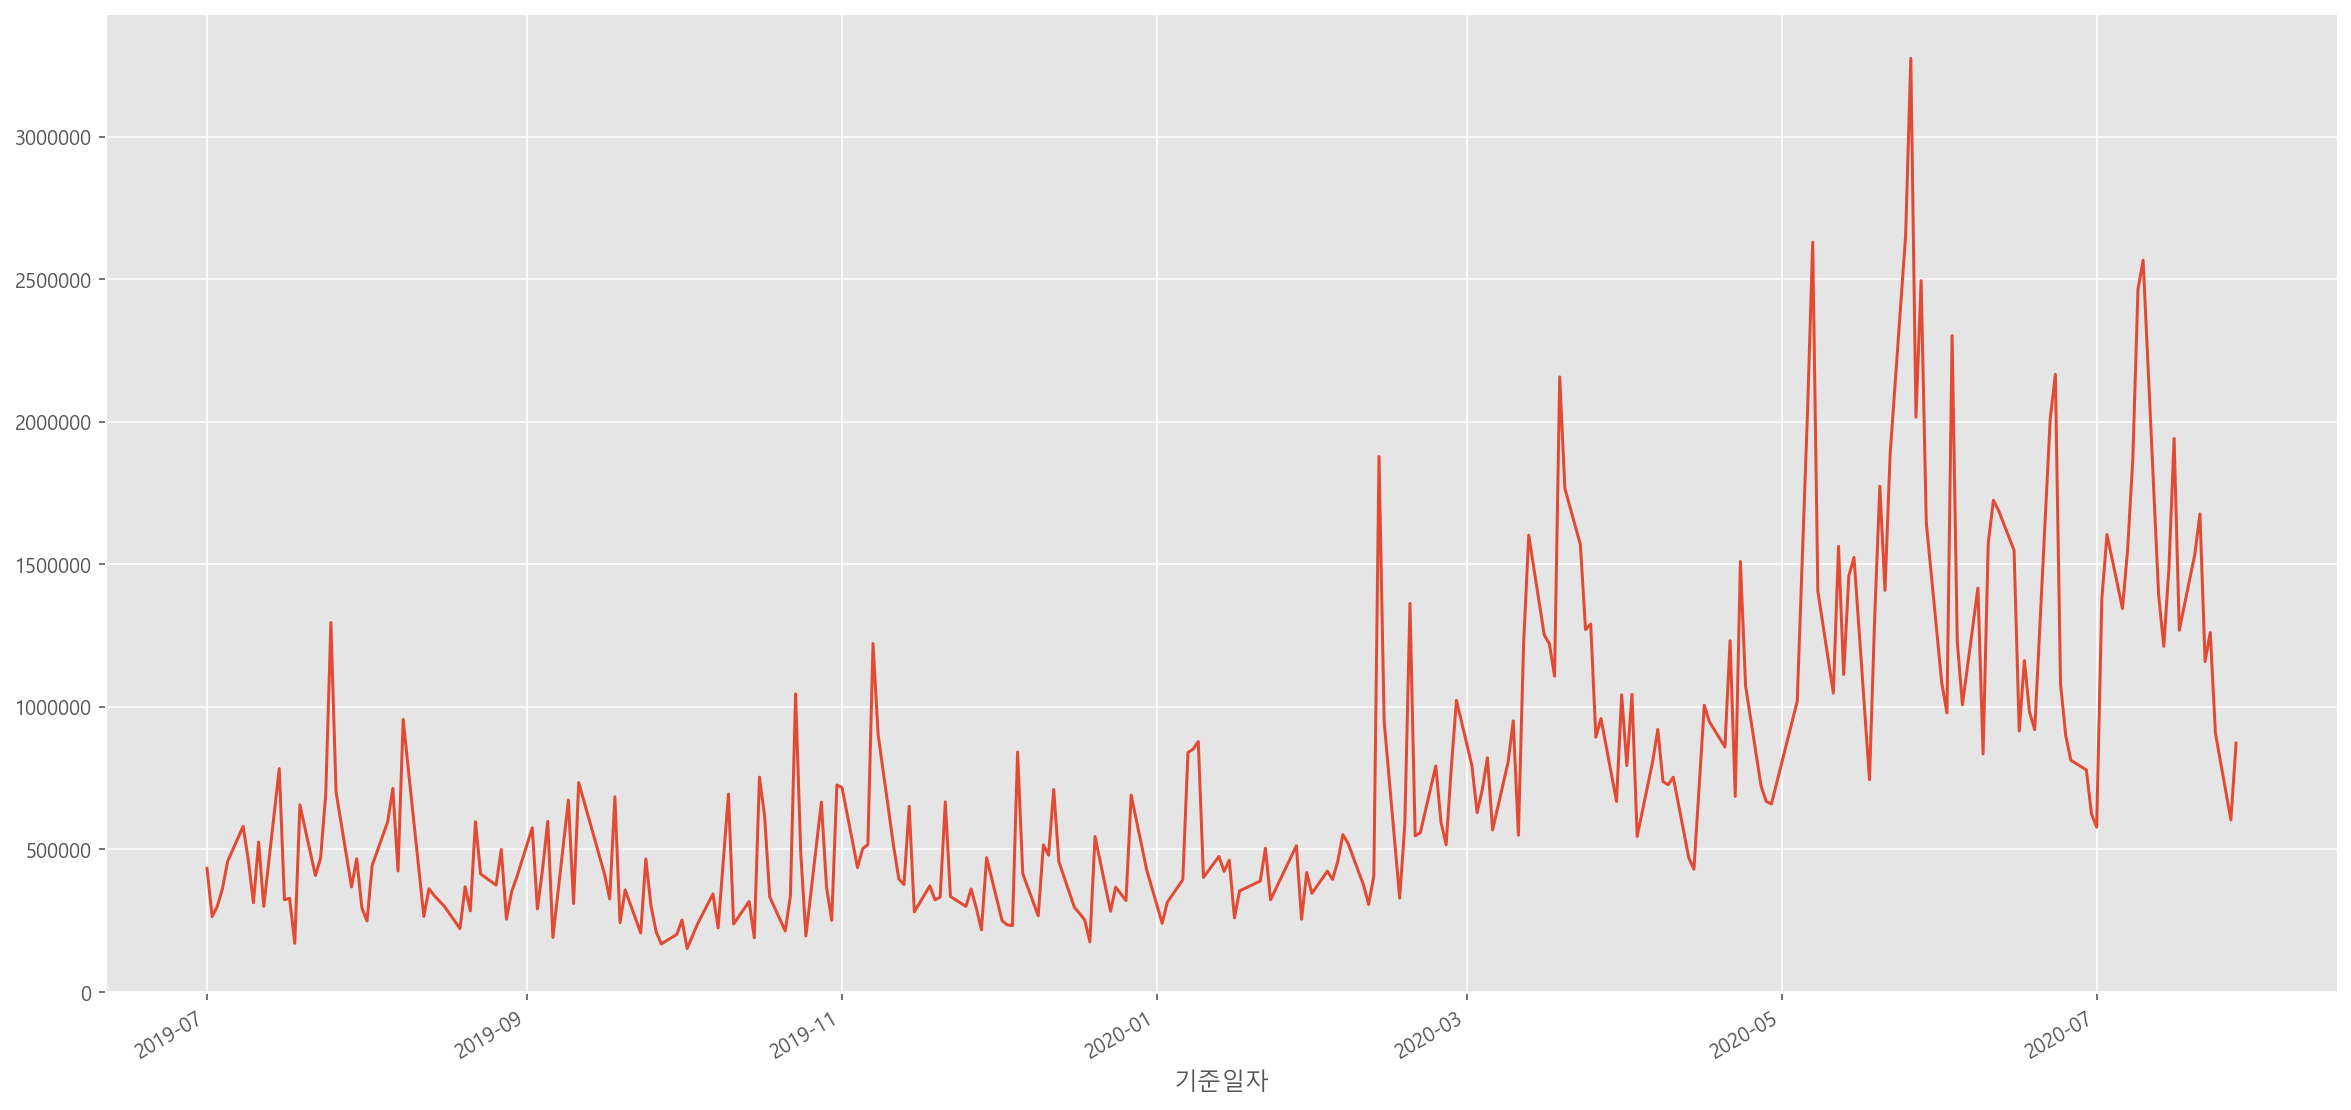

In [137]:
event_plot('A035720','거래량',data_stocks)

* 3월부터 6월까지 top3에 있으면 무조건 정답
* 한번이라도 빠졌으면?
* 씨젠은 왜 안사냐?
    * 7월
    * 2020년 3월 진단키트 개발로 인해 씨젠 가격 5배 급등, 이미 너무 높아짐
    * '백신'소식에 파미셀·에이비프로바이오 급등 2020년 5월
    * 신풍제약: 
         * 2020년 7월 거래정지 2번이나 당할정도로 거래량 많음
         * 신풍제약은 5월에 처음 승인받으면서 알려짐
         * 코로나 임상 실험의 희소식으로 인해 제약주 7월 주가 상승

In [95]:
top3_list = [data_train[(data_train['기준년월']==i)&(data_train['그룹번호']==j)].sort_values('매수고객수',ascending=False).iloc[:3]
            for i in month_list
            for j in group_list]

top3_list = pd.concat(top3_list)
top3_list['종목명'] = top3_list['종목번호'].apply(lambda x: data_stocks[data_stocks['종목번호']==x].iloc[0,2])

In [149]:
print(mad[1])

['미래에셋대우', 'NAVER', '두산인프라코어', 'SK하이닉스', '삼성전자', '신라젠', '에이치엘비', '두산퓨얼셀', 'LG전자', '이마트', '현대건설', '현대차', '한샘', 'SK이노베이션', 'CJCGV', '두산', '기아차', '대한항공', '삼성전자우', '한국전력', 'SK텔레콤', '아시아나항공', '삼성생명', 'LG디스플레이', '카카오', 'LG화학', '신한지주', '셀트리온', '셀트리온헬스케어', '씨젠', 'KB금융', '한진칼', '삼성바이오로직스', '호텔신라', '삼성중공업', '케이엠더블유', 'CJ대한통운', 'GS건설', '롯데케미칼', '현대엘리베이', 'JYPEnt']


In [160]:
data_stocks[data_stocks['종목명']=='롯데케미칼'].head(1)

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,비중,기준년월,월별_비율
193,20190701,A011170,롯데케미칼,N,코스피,제조업,화학물질 및 화학제품 제조업;,기초 화학물질 제조업,257000,261500,255000,256000,86010,2216619,0.0001,201907,0.000118


In [161]:
data_train[(data_train['그룹번호']=='MAD02')&(data_train['종목번호']=='A011170')]

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
25334,202006,MAD02,112,A011170,Y,N,3,0,51,0,168000,-1


In [162]:
top3_list[(top3_list['그룹번호']=='MAD12')&(top3_list['기준년월']>=202003)]

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값,종목명
14698,202003,MAD12,152,A005930,Y,Y,38,20,183,146,47790,48900,삼성전자
14696,202003,MAD12,152,A005380,Y,Y,15,9,84,95,80141,82755,현대차
14694,202003,MAD12,152,A000660,Y,Y,13,10,22,24,81650,84700,SK하이닉스
18296,202004,MAD12,152,A005930,Y,Y,22,16,91,250,48750,49877,삼성전자
18294,202004,MAD12,152,A005380,Y,Y,14,14,72,53,94000,96000,현대차
18310,202004,MAD12,152,A068270,Y,Y,12,14,246,258,207166,205666,셀트리온
22483,202005,MAD12,152,A035720,Y,Y,25,18,13,11,260000,251075,카카오
22473,202005,MAD12,152,A005930,Y,Y,17,11,84,127,48778,49950,삼성전자
22476,202005,MAD12,152,A006800,Y,Y,13,10,1597,2094,5820,6162,미래에셋대우
26722,202006,MAD12,152,A035420,Y,Y,27,27,20,31,252500,243375,NAVER


In [119]:
asw[:29]

,그룹번호,종목번호1,종목번호2,종목번호3
0,MAD01,SK하이닉스,삼성전자,삼성전자우
1,MAD02,대한항공,미래에셋대우,삼성전자
2,MAD03,부광약품,신풍제약,일양약품
3,MAD04,SK하이닉스,삼성전자,신풍제약
4,MAD05,NAVER,셀트리온,카카오
5,MAD06,NAVER,삼성전자,카카오
6,MAD07,SK이노베이션,SOil,삼성전자
7,MAD08,SK케미칼,부광약품,신풍제약
8,MAD09,LG화학,NAVER,카카오
9,MAD10,KT,삼성전자우,한국전력
